# Notebook For Figure 3 Method Paper

### Imports  
All functions are in behavior_analysis_functions.py

In [1]:
import os
import glob
from processing_TowerCoordinates import *
from processing_session_trajectory import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.path as mpath
import matplotlib.cm as cm
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pickle
import scipy.ndimage as ndimage
from scipy.stats import wilcoxon
from processing_TowerCoordinates import *
from datetime import date
from scipy.ndimage import gaussian_filter as smooth
import matplotlib.colors as mcolors
from matplotlib.backends.backend_pdf import PdfPages

import warnings 
from matplotlib.colors import LinearSegmentedColormap


plt.style.use('paper.mplstyle')

#from PlottingFunctions import *





# Getting mice data
Define the folder where your MOUXXX folder are, generate a list of MOUXXX folders and for each mice a list of sessions

In [2]:
# Finding and importing data

# indicate where the data are
# path_to_data_folder is the path of the folder where you store your different mice.

# Windows:
# path_to_data_folder='C:'+os.sep+'Users'+os.sep+'MORVAN'+os.sep+'Documents'+os.sep+'patchouris'+os.sep+'Sample_Data'+os.sep
# Linux:
# path_to_data_folder '/home/david/Documents/Code/ForagingProject/Patchouris/patchouris/Sample_Data/'
# MacOs
#path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/'


#path_to_data_folder='/home/david/Documents/David/Data/'
#path_to_data_folder='/LocalData/ForagingMice/JAK2Data'
#path_to_data_folder='/LocalData/ForagingMice/MaudData'
path_to_data_folder='/LocalData/ForagingMice/4TowerTaskMethodPaper/MaudData'
#path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/KenzaData'


pattern_of_MOU_Folders = os.path.join(path_to_data_folder, "MOU*")

# List all mice in the data folder (If you want to analyse all the mice in your data folder),
mice_list = [os.path.basename(path) for path in glob.glob(pattern_of_MOU_Folders)]
mice_list=sorted(mice_list)

# Print the number of mice, the list of mice, and add an empty line
print(f'Found {len(mice_list)} {"mice" if len(mice_list) > 1 else "mouse"} in the data folder: {", ".join(mice_list)}\n')


#If you want to analyse a subset of mice uncomment the line below and comment the 2 lines above

#mice_list: list[str] = ["MOU2334"]  # For analysing  a single mice. Equivalent to mice_list = ["MOU2334"] but more correct as it forces to create a list of string
#mice_list=['MOU2329', 'MOU2330', 'MOU2331', 'MOU2332', 'MOU2333', 'MOU2334']
#print(f'Found {len(mice_list)} {"mice" if len(mice_list) > 1 else "mouse"} in the data folder:')

session_list = {}
for mouse in mice_list:
    mouse_folder = os.path.join(path_to_data_folder,mouse)
    session_list[mouse] = sorted([name for name in os.listdir(mouse_folder)
                           if os.path.isdir(os.path.join(mouse_folder, name))
                           and name.startswith('MOU')])
    nb_sessions = len(session_list[mouse])
    print(f'Hello, I\'m {mouse}! I have foraged for {nb_sessions} sessions:')
    print(session_list[mouse], '\n')


Found 30 mice in the data folder: MOU3974, MOU3975, MOU3987, MOU3988, MOU3991, MOU3992, MOU4122, MOU4123, MOU4124, MOU4172, MOU4175, MOU4183, MOU4185, MOU4186, MOU4192, MOU4551, MOU4552, MOU4560, MOU4561, MOU4562, MOU4563, MOU4623, MOU4624, MOU4692, MOU4694, MOU4695, MOU4696, MOU4698, MOU4703, MOU4704

Hello, I'm MOU3974! I have foraged for 46 sessions:
['MOU3974_20230304-1314', 'MOU3974_20230305-1535', 'MOU3974_20230306-1211', 'MOU3974_20230306-1752', 'MOU3974_20230307-1231', 'MOU3974_20230307-1742', 'MOU3974_20230308-1150', 'MOU3974_20230308-1714', 'MOU3974_20230309-1155', 'MOU3974_20230309-1705', 'MOU3974_20230310-1220', 'MOU3974_20230310-1702', 'MOU3974_20230311-1258', 'MOU3974_20230311-1801', 'MOU3974_20230312-1145', 'MOU3974_20230312-1648', 'MOU3974_20230313-1129', 'MOU3974_20230313-1725', 'MOU3974_20230314-1036', 'MOU3974_20230314-1620', 'MOU3974_20230315-1155', 'MOU3974_20230315-1722', 'MOU3974_20230316-1145', 'MOU3974_20230316-1653', 'MOU3974_20230317-1141', 'MOU3974_20230317-

# Definition of functions

In [3]:
# def cm2inch(value):
def cm2inch(value):
    return value/2.54

In [4]:
def detect_run_epochs(speeds, time_video_frames):
    """
    
    Identifies continuous epochs during which the mouse is moving above a certain speed (cut_off_speed).
    A minimal duration of low speed is necessary to be considered as the end of a run.
    Similarly, a minimal duration of high speed is necessary to be considered as a run.
    """
    
    #for this we need some parameters to cut the trajectory into run based on speed, duration of runs and pauses
    pause_min_duration = 0.1 #if a stop is shorter than this, merges the two epochs bordering it
    run_min_duration = 0.3 #minimal duration of an epoch to be considerd
    cut_off_speed = 7 # this value is the speed in cm/s. It is used to detect when the animals stop running. 
    
    
    
    run_epochs = []
    is_in_epoch = False  # Flag to track if we are currently in a running epoch
    epoch_start_index = 0

    if len(speeds) != len(time_video_frames):
        raise ValueError("speeds and time_video_frames have different lengths")

    for i in range(len(speeds)):
        if speeds[i] >= cut_off_speed:  # Speed above cut-off value
            if not is_in_epoch: # if the previous trajectory speed was not part of running epoch then this will be a start of a new epoch
                epoch_start_index = i  # Mark the beginning of a new epoch
                is_in_epoch = True
        else: # the speed of the current data point is below the treshold
            if is_in_epoch: # if we were in a run epoch just before (1st point below the treshold)
                # Check first if the pause between this epoch's starting point (time_video_frames[epoch_start_index]) and  
                # the previous epoch' last point time_video_frames[run_epochs[-1][1]] is shorter than the minimal time for a pause
                # then the previous epoch  should be extended to the previous data point.  
                if run_epochs and (time_video_frames[epoch_start_index] - time_video_frames[run_epochs[-1][1]] < pause_min_duration):
                    run_epochs[-1][1] = i - 1  # Extend the previous epoch
                else: # the pause has been long enough then we terminate the run epoch  other previous 
                    run_epochs.append([epoch_start_index, i - 1])  # Add new epoch
                is_in_epoch = False

    # Final check for any epoch still in progress
    if is_in_epoch:
        if run_epochs and (time_video_frames[epoch_start_index] - time_video_frames[run_epochs[-1][1]] < pause_min_duration):
            run_epochs[-1][1] = len(speeds) - 1
        elif (time_video_frames[-1] - time_video_frames[epoch_start_index]) >= run_min_duration:
            run_epochs.append([epoch_start_index, len(speeds) - 1])

    # Remove epochs that are too short
    run_epochs = [epoch for epoch in run_epochs if (time_video_frames[epoch[1]] - time_video_frames[epoch[0]]) >= run_min_duration]
    
    # Adjust the start and end of each epoch based on acceleration. The idea is that with the threshold method we miss the beginning and enf of the run
    # for the starting point. We are going back and find the point at wich the animal acceleration is less than 40% 
    # than the acceleration at the moment at which he passed the treshold. 
    clean_run_epochs = [None] * len(run_epochs)
    for index,epoch in enumerate(run_epochs):
        clean_run_epochs[index] = epoch.copy()
        epoch_start, epoch_end = epoch[0], epoch[1]
        # Adjust the start of the epoch
        current_point = epoch_start
        acceleration_at_crossing=(speeds[current_point + 1] - speeds[current_point]) / (time_video_frames[current_point + 1] - time_video_frames[current_point])
        while current_point > 0:
            previous_acceleration = (speeds[current_point] - speeds[current_point - 1]) / (time_video_frames[current_point] - time_video_frames[current_point - 1])
            if previous_acceleration <= (0.1 * acceleration_at_crossing) or previous_acceleration <= 0:
                break
            current_point -= 1
            #print(f'it went backward on epoch {index}')
        clean_run_epochs[index][0] = current_point

    #Adjust the end of the epoch
    #We are going forward after the speed crossed downward the speed threshold and find the point at wich the animal acceleration is less than 40% 
    #than the acceleration at the moment at which it passed the treshold. 
        current_point = epoch_end
        acceleration_at_crossing=(speeds[current_point - 1] - speeds[current_point]) / (time_video_frames[current_point] - time_video_frames[current_point-1])
        while current_point < len(speeds) - 1:
            next_acceleration = (speeds[current_point] - speeds[current_point + 1]) / (time_video_frames[current_point+1] - time_video_frames[current_point])
            if next_acceleration <= (0.1 * acceleration_at_crossing) or next_acceleration <= 0:
                break
            current_point += 1
            #print(f'it went forward on epoch {index}')
        clean_run_epochs[index][1] = current_point

    
   
    return run_epochs, clean_run_epochs

In [5]:
def find_run_type(run_epoch, folder_path_mouse_to_analyse, session_to_analyse):

    # Define the pickle file path
    output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"
    output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)
    
    # Load the pickle file
    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    
    run_around_tower_ids = np.array([item[0] for item in session_data['all_epochs']['run_around_tower']])
    run_between_towers_ids = np.array([item[0] for item in session_data['all_epochs']['run_between_towers']])
    exploratory_run_ids = np.array([item[0] for item in session_data['all_epochs']['exploratory_run']])
    run_toward_tower_ids = np.array([item[0] for item in session_data['all_epochs']['run_toward_tower']])
    #print(immobility_ids)
    immobility_ids = np.array([[item[0],item[1]] for item in session_data['all_epochs']['immobility']])
    
    # condition_1 = np.logical_and(run_around_tower_ids[0][:]<=run_epoch[0],run_around_tower_ids[1][:]>run_epoch[1])
    # condition_2 = np.logical_and(run_between_towers_ids[0][:]<=run_epoch[0],run_between_towers_ids[1][:]>run_epoch[1])
    # condition_3 = np.logical_and(run_toward_tower_ids[0][:]<=run_epoch[0],run_toward_tower_ids[1][:]>run_epoch[1])
    # condition_4 = np.logical_and(exploratory_run_ids[0][:]<=run_epoch[0],exploratory_run_ids[1][:]>run_epoch[1])
    # condition_5 = np.logical_and(immobility_ids[0][:]<=run_epoch[0],immobility_ids[1][:]>run_epoch[1])
    
    condition_1 = run_epoch in run_around_tower_ids
    condition_2 = run_epoch in run_between_towers_ids
    condition_3 = run_epoch in run_toward_tower_ids
    condition_4 = run_epoch in exploratory_run_ids
    condition_5 = run_epoch in immobility_ids
    

    if np.any(condition_1):
    
        epoch_type = "run_around_tower"
        
    elif np.any(condition_2):
    
        epoch_type = "run_between_towers"

    elif np.any(condition_3):
    
        epoch_type = "run_toward_tower"    

    elif np.any(condition_4):
    
        epoch_type = "exploratory_run"

    elif np.any(condition_5):
    
        epoch_type = "immobility"    

    else:
        
        print("WARNING: unclassified epoch")
        epoch_type = "unclassified"

    print(f"Epoch type found for epoch: {run_epoch}")


    return epoch_type


In [6]:
def finding_session_rewarded_direction(folder_path_mouse_to_analyse, session_to_analyse):
# Looking for the rewarded direction FOR ALL THE SESSIONS

    # sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
    #                               if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
    #                               and name.startswith('MOU')])

    #output_pickle_filename = f"{sessions_to_analyse[-1]}_basic_analysing_output.pickle"
    #output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, sessions_to_analyse[-1], output_pickle_filename)

    #with open(output_pickle_filepath, 'rb') as file:
    #        session_data = pickle.load(file)

    # session_traj_df, session_turns_df, session_param_df=load_data(folder_path_mouse_to_analyse,sessions_to_analyse[-1])

    session_traj_df, session_turns_df, session_param_df=load_data(folder_path_mouse_to_analyse,session_to_analyse)


    rewarded_direction_degrees = session_param_df["potentialRewardedDirections"][0]

    if rewarded_direction_degrees == '[270]':

        rewarded_direction = 'CW'

    elif rewarded_direction_degrees == '[90]':
        
        rewarded_direction = 'CCW'
        
    elif rewarded_direction_degrees == '[90, 270]':
    
        rewarded_direction = 'both'

    else:

        print('ERROR')

        return 

    return rewarded_direction
    
    #

In [7]:
def is_rewarding_allowed(folder_path_mouse_to_analyse, session_to_analyse):

    session_traj_df, session_turns_df, session_param_df=load_data(folder_path_mouse_to_analyse,session_to_analyse)

    rewarding_session = session_param_df["allowRewardDelivery"][0]

    return rewarding_session
    
    #

In [8]:
def is_rewarding_allowed(folder_path_mouse_to_analyse, session_to_analyse):

    session_traj_df, session_turns_df, session_param_df=load_data(folder_path_mouse_to_analyse,session_to_analyse)

    rewarding_session = session_param_df["allowRewardDelivery"][0]

    return rewarding_session
    

In [9]:
def is_injection(folder_path_mouse_to_analyse, session_to_analyse):

    session_traj_df, session_turns_df, session_param_df=load_data(folder_path_mouse_to_analyse,session_to_analyse)

    if 'injectionCNO' in session_param_df.keys():

        bool_injection = not(session_param_df["injectionCNO"][0] == 'none')

    else :

        print("No injectionCNO key")
        bool_injection = False

    return bool_injection
    

In [10]:
def when_injection(folder_path_mouse_to_analyse):

    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                    if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                    and name.startswith('MOU')])
    
    injection_session_idx = []

    for idx, session in enumerate(sessions_to_analyse):

        if is_injection(folder_path_mouse_to_analyse, session):

            injection_session_idx.append(idx)

            if idx != 0:

                return injection_session_idx

    
    return injection_session_idx


In [11]:
def towers_coordinates_as_dictionnary(towers_coordinates_cm):

    # Define new dictionary with explicit corner names
    towers_coordinates_as_dict = {}

    # Corner names in order
    corner_names = ['NW', 'NE', 'SE', 'SW']

    # Map tower coordinates to corner names
    for tower, coordinates in towers_coordinates_cm.items():
        towers_coordinates_as_dict[tower] = {corner_names[i]: coord for i, coord in enumerate(coordinates)}

    return towers_coordinates_as_dict


In [12]:
def get_tower_and_corner(run_around_tower):
    # Get the label of the tower and corner  around wich a run around tower is happening based on the  second and third elements saved in run_epochs['run_around_tower']
    tower_name = run_around_tower[1][0]  # First element, 'NE', gives the tower
    start_face = run_around_tower[1][1]  # 'W' for west, gives the starting face
    end_face = run_around_tower[2][1]    # 'S' for south, gives the ending face
    
    # Determine the corner based on the start and end faces
    if start_face == 'W' and end_face == 'S':
        corner = 'SW'
    elif start_face == 'S' and end_face == 'E':
        corner = 'SE'
    elif start_face == 'E' and end_face == 'N':
        corner = 'NE'
    elif start_face == 'N' and end_face == 'W':
        corner = 'NW'
    elif start_face == 'W' and end_face == 'N':
        corner = 'NW'
    elif start_face == 'N' and end_face == 'E':
        corner = 'NE'
    elif start_face == 'E' and end_face == 'S':
        corner = 'SE'
    elif start_face == 'S' and end_face == 'W':
        corner = 'SW'
    else:
        corner = None  # Handle unexpected cases
    
    return tower_name, corner

In [13]:
def plot_trajectories(trajectories,marker='o'):
    """
    Plot all trajectories on the same plot.
    
    Parameters:
        trajectories (list): A list of 2D numpy arrays of shape (2, X) representing the trajectories.
    """
    plt.figure(figsize=(8, 6))
    
    # Plot each trajectory
    for trajectory in trajectories:
        plt.plot(trajectory[0, :], trajectory[1, :], marker=marker, linestyle='-', label='Trajectory')
        plt.scatter(trajectory[0, 0], trajectory[1, 0], color='green', marker='o', edgecolor='green', label='Start Point',s=40)
        plt.scatter(trajectory[0, -1], trajectory[1, -1], color='red', marker='o', edgecolor='red', label='End Point',s=40) 
    
    # Add labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('All Trajectories')
    plt.grid(True)
    
    # Show the plot
    plt.show()

In [14]:
def rotate_SWtrajectory_90_ccw(trajectory):
    rotation_matrix = np.array([[0, -1], [1, 0]])
    return rotation_matrix @ trajectory


In [15]:
def rotate_NWtrajectory_180_ccw(trajectory):
    return -trajectory


In [16]:
def rotate_NEtrajectory_270_ccw(trajectory):
    rotation_matrix = np.array([[0, 1], [-1, 0]])
    return rotation_matrix @ trajectory


In [17]:
def resample_trajectory(trajectory, target_size):
    """
    Resample a single trajectory to have the target number of points.
    
    Parameters:
        trajectory (np.ndarray): A 2D numpy array of shape (2, X).
        target_size (int): The target number of points (X).
        
    Returns:
        np.ndarray: A 2D numpy array of shape (2, target_size).
    """
    # Get current number of points
    current_size = trajectory.shape[1]
    
    # Create an array of indices for the original points and the target points
    original_indices = np.linspace(0, current_size - 1, num=current_size)
    target_indices = np.linspace(0, current_size - 1, num=target_size)
    
    # Resample by interpolating the trajectory for each row (x and y coordinates)
    resampled_trajectory = np.array([np.interp(target_indices, original_indices, trajectory[i, :])
                                     for i in range(2)])
    
    return resampled_trajectory



In [18]:
def resample_all_trajectories(all_trajectories, target_size):
    """
    Resample all trajectories to have the same target number of points.
    
    Parameters:
        all_trajectories (list): A list of 2D numpy arrays of shape (2, X).
        target_size (int): The target number of points for each trajectory.
        
    Returns:
        list: A list of resampled 2D numpy arrays of shape (2, target_size).
    """
    resampled_trajectories = [resample_trajectory(trajectory, target_size) for trajectory in all_trajectories]
    return resampled_trajectories


In [19]:
def compute_pairwise_correlations(trajectories):
    """Compute pairwise correlations between trajectories."""
    num_trajectories = len(trajectories)
    print(f"Number of trajectories: {num_trajectories}")
    correlations = []
    
    for i in range(num_trajectories):
        for j in range(i + 1, num_trajectories):
            traj1 = trajectories[i]
            #print(len(traj1))
            traj2 = trajectories[j]
            #print(len(traj2))
            
            # Flatten trajectories for correlation computation
            traj1_flat = traj1.flatten()
            #print(len(traj1_flat))
            traj2_flat = traj2.flatten()
            #print(len(traj2_flat))
            
            # Compute correlation coefficient
            corr = np.corrcoef(traj1_flat, traj2_flat)[0, 1]
            correlations.append(corr)
    
    return correlations

In [20]:
def accumulation_threshold(cummulated_events_time, threshold=0.8):

    i = 0

    if len(cummulated_events_time) != 0:
        
        fraction_of_events = (i+1)/len(cummulated_events_time)
    
    else:

        return 0

    while fraction_of_events<threshold:

        i = i + 1
        fraction_of_events = (i+1)/len(cummulated_events_time)

    return cummulated_events_time[i]

In [21]:
def cumulated_goodbad_turns_time_profile(folder_path_mouse_to_analyse, session_to_analyse, time_start=None, time_end=None):

    output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"        
    output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)

    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    traject_time = session_data['timeofframes']

    if time_start is None:
        time_start = traject_time[0]
    if time_end is None:
        time_end = traject_time[-1]
  
    runs_around_tower = copy.deepcopy(session_data['all_epochs']['run_around_tower'])

    runs_around_tower_to_keep = []

    time_of_runsaroundtower_CW = []
    time_of_runsaroundtower_CCW = []

    for run_around_tower in runs_around_tower:
        
        # if run_around_tower[3]['num_trapezeswitch'] > 1:
        #     continue

        start_index, end_index = run_around_tower[0][0], run_around_tower[0][1]

        if traject_time[start_index]<time_start or traject_time[end_index]>time_end:
        
            continue
        
        if run_around_tower[3]['direction'] == 'CW':
        
            time_of_runsaroundtower_CW.append(run_around_tower[4]['epoch_time'])

        if run_around_tower[3]['direction'] == 'CCW':
        
            time_of_runsaroundtower_CCW.append(run_around_tower[4]['epoch_time'])


        runs_around_tower_to_keep.append(run_around_tower)

    CW_times_sorted = np.sort(time_of_runsaroundtower_CW)
    CCW_times_sorted = np.sort(time_of_runsaroundtower_CCW)

    CW_cumulative = np.arange(1, len(CW_times_sorted) + 1)
    CCW_cumulative = np.arange(1, len(CCW_times_sorted) + 1)

    rewarded_direction = finding_session_rewarded_direction(folder_path_mouse_to_analyse, session_to_analyse)
    
    if rewarded_direction == 'CW': #'[270]':

        good_turns_time = CW_times_sorted
        bad_turns_time = CCW_times_sorted

        cumulated_good_turns = CW_cumulative
        cumulated_bad_turns = CCW_cumulative

    elif rewarded_direction == 'CCW': #'[90]':
        
        good_turns_time = CCW_times_sorted
        bad_turns_time = CW_times_sorted
        
        cumulated_good_turns = CCW_cumulative
        cumulated_bad_turns = CW_cumulative
    
    elif rewarded_direction == 'both': #'[90]':
    
        good_turns_time =  np.sort(np.concatenate((time_of_runsaroundtower_CW,time_of_runsaroundtower_CCW)))
        bad_turns_time = np.zeros(len(good_turns_time))
        
        cumulated_good_turns = np.arange(1, len(good_turns_time) + 1)
        cumulated_bad_turns = np.zeros(len(cumulated_good_turns))
    
    else:

        print('ERROR')

        return 
    
    return [good_turns_time, cumulated_good_turns], [bad_turns_time, cumulated_bad_turns]
    

In [22]:
def cumulated_turns_time_profile(folder_path_mouse_to_analyse, session_to_analyse, time_start=None, time_end=None):

    output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"        
    output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)

    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    traject_time = session_data['timeofframes']

    if time_start is None:
        time_start = traject_time[0]
    if time_end is None:
        time_end = traject_time[-1]
  
    runs_around_tower = copy.deepcopy(session_data['all_epochs']['run_around_tower'])

    runs_around_tower_to_keep = []

    time_of_runsaroundtower_CW = []
    time_of_runsaroundtower_CCW = []

    for run_around_tower in runs_around_tower:
        
        # if run_around_tower[3]['num_trapezeswitch'] > 1:
        #     continue

        start_index, end_index = run_around_tower[0][0], run_around_tower[0][1]

        if traject_time[start_index]<time_start or traject_time[end_index]>time_end:
        
            continue
        
        if run_around_tower[3]['direction'] == 'CW':
        
            time_of_runsaroundtower_CW.append(run_around_tower[4]['epoch_time'])

        if run_around_tower[3]['direction'] == 'CCW':
        
            time_of_runsaroundtower_CCW.append(run_around_tower[4]['epoch_time'])


        runs_around_tower_to_keep.append(run_around_tower)

    CW_times_sorted = np.sort(time_of_runsaroundtower_CW)
    CCW_times_sorted = np.sort(time_of_runsaroundtower_CCW)

    CW_cumulative = np.arange(1, len(CW_times_sorted) + 1)
    CCW_cumulative = np.arange(1, len(CCW_times_sorted) + 1)

    return [CW_times_sorted, CW_cumulative], [CCW_times_sorted, CCW_cumulative]
    

In [23]:
def find_rewarding_range(folder_path_mouse_to_analyse,session_to_analyse):

    session_traj_df, session_turns_df, session_param_df=load_data(folder_path_mouse_to_analyse,session_to_analyse)

    session_type = eval(list(session_param_df['range_maxConsecRewards'])[0])

    return session_type

In [24]:
def check_alternation(folder_path_mouse_to_analyse, session_limit):

    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                    if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                    and name.startswith('MOU')])

    sessions_to_analyse = sessions_to_analyse[:session_limit]

    rewarded_direction_per_session = []

    for session in sessions_to_analyse:

        rewarded_direction_per_session.append(finding_session_rewarded_direction(folder_path_mouse_to_analyse, session))

    for i in range(2,len(rewarded_direction_per_session)):

        if rewarded_direction_per_session[i] == rewarded_direction_per_session[i-2]:

            print(f"ERROR: The rewarded direction is not alternating every day for mouse {folder_path_mouse_to_analyse[-7:]} in session {i+1} or {i-1}")
            print(rewarded_direction_per_session)

            return False
        
    return True

In [25]:
def separate_directions(path_to_data_folder, mice, session_limit=None):

    CW_mice = []
    CCW_mice = []

    for mouse in mice:

        folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)
        
        if not(check_alternation(folder_path_mouse_to_analyse, session_limit)):

            print(f"Excluding {mouse}")

            continue

        # Get the list of sessions
        sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                    if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                    and name.startswith('MOU')])

        sessions_to_analyse = sessions_to_analyse[:session_limit]

        first_rewarded_direction = finding_session_rewarded_direction(folder_path_mouse_to_analyse, sessions_to_analyse[4])

        if first_rewarded_direction == 'CW':

            CW_mice.append(mouse)

        elif first_rewarded_direction == 'CCW':

            CCW_mice.append(mouse)

        else:
            
            print('No unique rewarded direction')
            return

        when_injection(folder_path_mouse_to_analyse)

    return CW_mice, CCW_mice



# Computations

In [26]:
"""days_since_last_session = []

n = 0

for mouse in mice_list:

    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)

    # Get the list of sessions
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                and name.startswith('MOU')])

    days_since_last_session.append([])

    for i in np.arange(1,len(sessions_to_analyse)):

        session_name = sessions_to_analyse[i]
        previous_session_name = sessions_to_analyse[i-1]

        year = int(session_name[9:13]) 
        month = int(session_name[13:15])
        day = int(session_name[15:17])

        previous_year = int(previous_session_name[9:13]) 
        previous_month = int(previous_session_name[13:15])
        previous_day = int(previous_session_name[15:17])

        d0 = date(year, month, day)
        d1 = date(previous_year, previous_month, previous_day)

        delta = d0 - d1

        days_since_last_session[n].append(delta.days)

    n = n + 1

mice_to_analyse = [] 
rejected_mice = []

for i in range(len(mice_list)):

    nb_sessions = len(days_since_last_session[i]) + 1

    sessions_after_weekend = np.where(np.array(days_since_last_session[i])>1)[0] + 2

    sessions_after_weekend = np.array(sessions_after_weekend)

    consecutive_sessions = [0]
    k = 0

    print(f"#### {mice_list[i]} ####")

    for j in range(nb_sessions):

        if not(j+1 in sessions_after_weekend):

            consecutive_sessions[k] += 1

        else:

            consecutive_sessions.append(1)
            k += 1

    print("Length of consecutive sessions periods: ", consecutive_sessions)
    print("ID of sessions following a weekend: ", sessions_after_weekend)
    print("Days since last sessions: ", days_since_last_session[i])

    is_big_series = np.sum(consecutive_sessions[:2]) >= 11

    if len(consecutive_sessions) > 1:

        is_pause_at_good_time = (consecutive_sessions[0] == 1 or consecutive_sessions[0]>=11)

    else:

        is_pause_at_good_time = True


    elimination_condition = not(is_big_series and is_pause_at_good_time)
    #elimination_condition = np.logical_and(sessions_after_weekend<9, sessions_after_weekend>2)


    if elimination_condition :

        rejected_mice.append(mice_list[i])

        #print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        print("Removing this mouse", "\n")

    else:

        mice_to_analyse.append(mice_list[i])

        #print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        print("Keeping this mouse", "\n")

mice_to_analyse.remove('MOUKA274')
mice_to_analyse.remove('MOUKA275')
mice_to_analyse.remove('MOUKA276')

"""


'days_since_last_session = []\n\nn = 0\n\nfor mouse in mice_list:\n\n    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)\n\n    # Get the list of sessions\n    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)\n                                if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))\n                                and name.startswith(\'MOU\')])\n\n    days_since_last_session.append([])\n\n    for i in np.arange(1,len(sessions_to_analyse)):\n\n        session_name = sessions_to_analyse[i]\n        previous_session_name = sessions_to_analyse[i-1]\n\n        year = int(session_name[9:13]) \n        month = int(session_name[13:15])\n        day = int(session_name[15:17])\n\n        previous_year = int(previous_session_name[9:13]) \n        previous_month = int(previous_session_name[13:15])\n        previous_day = int(previous_session_name[15:17])\n\n        d0 = date(year, month, day)\n        d1 = dat

In [27]:
# Identifying sessions following a weekend

session_limit = 20

days_since_last_session = []
rewarding_range = []

n = 0

for mouse in mice_list:
    
    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)
    
    #print(mouse)
    #print(when_injection(folder_path_mouse_to_analyse))

    # Get the list of sessions
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])

    sessions_to_analyse = sessions_to_analyse[:session_limit]
    #mice_path = '/LocalData/ForagingMice/4TowerTaskMethodPaper/MaudData/Method_Flex_270_dictionnary.pkl'
    #with open(mice_path, 'rb') as file:
    #    mice_sessions = pickle.load(file)


    days_since_last_session.append([])
    rewarding_range.append([])

    for i in np.arange(1,len(sessions_to_analyse)):

        session_name = sessions_to_analyse[i]
        previous_session_name = sessions_to_analyse[i-1]

        year = int(session_name[8:12]) 
        month = int(session_name[12:14])
        day = int(session_name[14:16])

        previous_year = int(previous_session_name[8:12]) 
        previous_month = int(previous_session_name[12:14])
        previous_day = int(previous_session_name[14:16])

        d0 = date(year, month, day)
        d1 = date(previous_year, previous_month, previous_day)

        delta = d0 - d1

        #sessions_date.append([year,month,day])
        days_since_last_session[n].append(delta.days)
        rewarding_range[n].append(find_rewarding_range(folder_path_mouse_to_analyse,sessions_to_analyse[i]))

    n = n + 1


mice_to_analyse = []
rejected_mice = []

for i in range(len(mice_list)):

    sessions_after_weekend = np.where(np.array(days_since_last_session[i])>1)[0] + 2

    sessions_after_weekend = np.array(sessions_after_weekend)

    elimination_condition = np.logical_and(sessions_after_weekend<20, sessions_after_weekend>2)

    sessions_before_limit = np.where(elimination_condition)[0]

    if sessions_before_limit.size == 0 :

        mice_to_analyse.append(mice_list[i])

        print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        #print(rewarding_range[i].count([1,2]), 'free exploration sessions')
        print("Keeping this mouse \n")

    else:

        rejected_mice.append(mice_list[i])

        print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        #print(rewarding_range[i].count([1,2]), 'free exploration sessions')
        print("Removing this mouse \n")
        

# Manually removing mice:

#mice_to_analyse.remove('MOUKA274')
#mice_to_analyse.remove('MOUKA275')
#mice_to_analyse.remove('MOUKA276')

(MOU3974) Those sessions were done after a weekend: []
Keeping this mouse 

(MOU3975) Those sessions were done after a weekend: []
Keeping this mouse 

(MOU3987) Those sessions were done after a weekend: []
Keeping this mouse 

(MOU3988) Those sessions were done after a weekend: []
Keeping this mouse 

(MOU3991) Those sessions were done after a weekend: []
Keeping this mouse 

(MOU3992) Those sessions were done after a weekend: []
Keeping this mouse 

(MOU4122) Those sessions were done after a weekend: [ 7 13]
Removing this mouse 

(MOU4123) Those sessions were done after a weekend: [ 7 13]
Removing this mouse 

(MOU4124) Those sessions were done after a weekend: [ 7 13]
Removing this mouse 

(MOU4172) Those sessions were done after a weekend: [15]
Removing this mouse 

(MOU4175) Those sessions were done after a weekend: [15]
Removing this mouse 

(MOU4183) Those sessions were done after a weekend: [15]
Removing this mouse 

(MOU4185) Those sessions were done after a weekend: [15]
Remo

In [28]:
"""days_since_last_session = []

n = 0

for mouse in mice_list:

    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)

    # Get the list of sessions
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                and name.startswith('MOU')])

    days_since_last_session.append([])

    for i in np.arange(1,len(sessions_to_analyse)):

        session_name = sessions_to_analyse[i]
        previous_session_name = sessions_to_analyse[i-1]

        year = int(session_name[9:13]) 
        month = int(session_name[13:15])
        day = int(session_name[15:17])

        previous_year = int(previous_session_name[9:13]) 
        previous_month = int(previous_session_name[13:15])
        previous_day = int(previous_session_name[15:17])

        d0 = date(year, month, day)
        d1 = date(previous_year, previous_month, previous_day)

        delta = d0 - d1

        days_since_last_session[n].append(delta.days)

    n = n + 1

mice_to_analyse = [] 
rejected_mice = []

for i in range(len(mice_list)):

    nb_sessions = len(days_since_last_session[i]) + 1

    sessions_after_weekend = np.where(np.array(days_since_last_session[i])>1)[0] + 2

    sessions_after_weekend = np.array(sessions_after_weekend)

    consecutive_sessions = [0]
    k = 0

    print(f"#### {mice_list[i]} ####")

    for j in range(nb_sessions):

        if not(j+1 in sessions_after_weekend):

            consecutive_sessions[k] += 1

        else:

            consecutive_sessions.append(1)
            k += 1

    print("Length of consecutive sessions periods: ", consecutive_sessions)
    print("ID of sessions following a weekend: ", sessions_after_weekend)
    print("Days since last sessions: ", days_since_last_session[i])

    if len(consecutive_sessions)>1:

        if consecutive_sessions[0] == 1:

            is_good_series = np.sum(consecutive_sessions[:2])>=9
            is_good_series = is_good_series and consecutive_sessions[2]>=9

        else:
            
            is_good_series = consecutive_sessions[0]>=9 and consecutive_sessions[1]>=9
        
    else:

        is_good_series = np.sum(consecutive_sessions[:1])>18

    # if len(consecutive_sessions) > 1:

    #     is_pause_at_good_time = (consecutive_sessions[0] == 1 or consecutive_sessions[0]>=11)

    # else:

    #     is_pause_at_good_time = True


    elimination_condition = not(is_good_series)
    #elimination_condition = not(is_big_series and is_pause_at_good_time)
    #elimination_condition = np.logical_and(sessions_after_weekend<9, sessions_after_weekend>2)


    if elimination_condition :

        rejected_mice.append(mice_list[i])

    #print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        print("Removing this mouse", "\n")

    else:

        mice_to_analyse.append(mice_list[i])

    #print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        print("Keeping this mouse", "\n")
"""

'days_since_last_session = []\n\nn = 0\n\nfor mouse in mice_list:\n\n    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)\n\n    # Get the list of sessions\n    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)\n                                if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))\n                                and name.startswith(\'MOU\')])\n\n    days_since_last_session.append([])\n\n    for i in np.arange(1,len(sessions_to_analyse)):\n\n        session_name = sessions_to_analyse[i]\n        previous_session_name = sessions_to_analyse[i-1]\n\n        year = int(session_name[9:13]) \n        month = int(session_name[13:15])\n        day = int(session_name[15:17])\n\n        previous_year = int(previous_session_name[9:13]) \n        previous_month = int(previous_session_name[13:15])\n        previous_day = int(previous_session_name[15:17])\n\n        d0 = date(year, month, day)\n        d1 = dat

In [29]:
print("Mice to analyse:\n", mice_to_analyse)
print(len(mice_list))

Mice to analyse:
 ['MOU3974', 'MOU3975', 'MOU3987', 'MOU3988', 'MOU3991', 'MOU3992', 'MOU4551', 'MOU4552', 'MOU4560', 'MOU4561', 'MOU4562', 'MOU4563', 'MOU4623', 'MOU4624']
30


In [30]:
def turns_by_patch(runs_around_tower, direction):

    visits = []

    previous_turn_patch = ''

    n = -1

    for run_around_tower in runs_around_tower:

        is_good_turn = run_around_tower[3]['direction'] == direction
        max_rewards = run_around_tower[3]['max_rewards']
        patch = run_around_tower[1][0]

        if patch != previous_turn_patch:

            n = n + 1
            
            visits.append({})

            visits[n]['turns'] = 1
            visits[n]['good_turns'] = int(is_good_turn)
            visits[n]['max_reward'] = max_rewards
            visits[n]['patch'] = patch
            visits[n]['visit_time'] = run_around_tower[4]['epoch_time']


        else:

            visits[n]['good_turns'] += int(is_good_turn)
            visits[n]['turns'] += 1

        previous_turn_patch = patch

    #print(visit)

    return visits


In [31]:
def compute_turns_per_visit(folder_path_mouse_to_analyse, session_to_analyse, direction):

    output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"
    output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)
            
    # Load the pickle file
    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    runs_around_towers = session_data['all_epochs']['run_around_tower']
        
    visit = turns_by_patch(runs_around_towers,direction)
    
    turns_per_visit = []
    visits_time = []
    max_rewards = []

    for i in range(len(visit)):

        nb_of_turns = visit[i]['good_turns']
        visit_time = visit[i]['visit_time']
        max_reward = visit[i]['max_reward']

        turns_per_visit.append(nb_of_turns)
        visits_time.append(visit_time)
        max_rewards.append(max_reward)


    return [turns_per_visit,visits_time,max_rewards]


In [65]:
# Initialize the dictionary with empty lists for each mouse
#mouse_data_persession = {mouse: [] for mouse in mice_to_analyse}

#mouse_rewardedturns_ratio_persession = {mouse: [] for mouse in mice_to_analyse}

#mouse_maximum_turn_speed_persession = {mouse: [] for mouse in mice_to_analyse}
#mouse_mean_turn_speed_persession = {mouse: [] for mouse in mice_to_analyse}

#mouse_average_speed_persession = {mouse: [] for mouse in mice_to_analyse}

mouse_total_turns_persession = {mouse: [] for mouse in mice_to_analyse}
#mouse_goodturns_ratio_persession = {mouse: [] for mouse in mice_to_analyse}
#mouse_total_goodturns_persession = {mouse: [] for mouse in mice_to_analyse}

#mouse_CW_persession = {mouse: [] for mouse in mice_to_analyse}
#mouse_CCW_persession = {mouse: [] for mouse in mice_to_analyse}

mouse_flex_ratio_persession = {mouse: [] for mouse in mice_to_analyse}

mouse_CW_number_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_CCW_number_persession = {mouse: [] for mouse in mice_to_analyse}

mouse_CW_meanspeeds_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_CCW_meanspeeds_persession = {mouse: [] for mouse in mice_to_analyse}

mouse_CW_threshold_persession = {mouse: [] for mouse in mice_to_analyse}
mouse_CCW_threshold_persession = {mouse: [] for mouse in mice_to_analyse}

mouse_mean_CW_turns_per_visit = {mouse: [] for mouse in mice_to_analyse}
mouse_mean_CCW_turns_per_visit = {mouse: [] for mouse in mice_to_analyse}

mouse_median_CW_turns_per_visit = {mouse: [] for mouse in mice_to_analyse}
mouse_median_CCW_turns_per_visit = {mouse: [] for mouse in mice_to_analyse}

for mouse in mice_to_analyse:
    
    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])

    sessions_to_analyse = sessions_to_analyse[:session_limit]
    
    #mice_path = '/LocalData/ForagingMice/4TowerTaskMethodPaper/MaudData/Method_Flex_270_dictionnary.pkl'
    #with open(mice_path, 'rb') as file:
    #    mice_sessions = pickle.load(file)

    #sessions_to_analyse = mice_sessions[mouse]



    nb_sessions = len(sessions_to_analyse)
    print(f'Mouse {mouse}. There is/are {nb_sessions} sessions:')
    print(sessions_to_analyse, '\n')


    # analyse each session
    for sessionindex,session_to_analyse in enumerate(sessions_to_analyse):
        #print(f'Getting the pickle file of session {session_to_analyse}')
        print(session_to_analyse, '#######', sessionindex)

        #rewarded_direction = finding_session_rewarded_direction(folder_path_mouse_to_analyse,session_to_analyse)
        
        #session_traj_df, session_turns_df, session_param_df=load_data(folder_path_mouse_to_analyse,session_to_analyse)


        # Define the pickle file path
        output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exists for session {session_to_analyse}, skipping .....')
            continue  # Skip loading if the file exists and overwrite is False
        
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)

        run_around_tower_sessionresult = session_data['run_around_tower_sessionresult']
        CWRatio = run_around_tower_sessionresult['All']['total_CW']/(run_around_tower_sessionresult['All']['total_CCW']+run_around_tower_sessionresult['All']['total_CW'])
        #print(" CWRatio = ", CWRatio)
        TotalTurns = run_around_tower_sessionresult['All']['total_CCW']+run_around_tower_sessionresult['All']['total_CW']
        TotalCW = run_around_tower_sessionresult['All']['total_CW']
        TotalCCW = run_around_tower_sessionresult['All']['total_CCW']
        flex_ratio = (TotalCW-TotalCCW)/(TotalCW+TotalCCW)
        #print(" TotalTurns = ", TotalTurns)
        # session_data["all_epochs"]["run_around_tower"][3]['direction']


        ####################

        # if rewarded_direction == 'CW':
            
        #     good_turns = run_around_tower_sessionresult['All']['total_CW']
                
        # elif rewarded_direction == 'CCW':
        
        #     good_turns = run_around_tower_sessionresult['All']['total_CCW']
        
        # else:

        #     good_turns = run_around_tower_sessionresult['All']['total_CW'] + run_around_tower_sessionresult['All']['total_CCW']
        
        ####################

        #turns_max_speed = []
        #turns_mean_speed = []

        mouse_CW_meanspeeds = []
        mouse_CCW_meanspeeds = []

        for n in range(len(session_data["all_epochs"]["run_around_tower"])):
    
            run = session_data["all_epochs"]["run_around_tower"][n]

            if run[3]['direction'] == 'CW':

                mouse_CW_meanspeeds.append(run[4]['epoch_meanspeed'])
            
            elif run[3]['direction'] == 'CCW':
            
                mouse_CCW_meanspeeds.append(run[4]['epoch_meanspeed'])
            
        CW_turns_per_visit = compute_turns_per_visit(folder_path_mouse_to_analyse, session_to_analyse, 'CW')[0]
        CCW_turns_per_visit = compute_turns_per_visit(folder_path_mouse_to_analyse, session_to_analyse, 'CCW')[0]

            #if run[3]['direction'] == rewarded_direction or rewarded_direction == 'both':
                
            #    turns_max_speed.append(run[4]["epoch_maxspeed"])
            #    turns_mean_speed.append(run[4]["epoch_meanspeed"])
                             

        #[good_turns_time, cumulated_good_turns], [bad_turns_time, cumulated_bad_turns] = cumulated_goodbad_turns_time_profile(folder_path_mouse_to_analyse, session_to_analyse, time_start=None, time_end=None)

        [CW_times_sorted, CW_cumulative], [CCW_times_sorted, CCW_cumulative] = cumulated_turns_time_profile(folder_path_mouse_to_analyse, session_to_analyse, time_start=None, time_end=None)        

        CW_threshold_time = accumulation_threshold(CW_times_sorted, threshold=0.2)
        CCW_threshold_time = accumulation_threshold(CCW_times_sorted, threshold=0.2)

        #mouse_data_persession[mouse].append([sessionindex+1,session_data['distance_ran']])
        
        #mouse_maximum_turn_speed_persession[mouse].append([sessionindex+1,np.nanmedian(turns_max_speed)])
        #mouse_mean_turn_speed_persession[mouse].append([sessionindex+1,np.nanmedian(turns_mean_speed)])

        #mouse_average_speed_persession[mouse].append([sessionindex+1,session_data['average_speed']])
        
        #mouse_goodturns_ratio_persession[mouse].append([sessionindex+1,good_turns/TotalTurns])
        mouse_total_turns_persession[mouse].append([sessionindex+1,TotalTurns])
        #mouse_total_goodturns_persession[mouse].append([sessionindex+1, good_turns])
        
        mouse_CW_threshold_persession[mouse].append([sessionindex+1, CW_threshold_time])
        mouse_CCW_threshold_persession[mouse].append([sessionindex+1, CCW_threshold_time])

        #mouse_CW_persession[mouse].append([sessionindex+1, run_around_tower_sessionresult['All']['total_CW']])
        #mouse_CCW_persession[mouse].append([sessionindex+1, run_around_tower_sessionresult['All']['total_CCW']])

        mouse_flex_ratio_persession[mouse].append([sessionindex+1, flex_ratio])
        
        mouse_CW_number_persession[mouse].append([sessionindex+1, run_around_tower_sessionresult['All']['total_CW']])
        mouse_CCW_number_persession[mouse].append([sessionindex+1, run_around_tower_sessionresult['All']['total_CCW']])

        mouse_CW_meanspeeds_persession[mouse].append([sessionindex+1, np.nanmedian(mouse_CW_meanspeeds)])
        mouse_CCW_meanspeeds_persession[mouse].append([sessionindex+1, np.nanmedian(mouse_CCW_meanspeeds)])
        mouse_mean_CW_turns_per_visit[mouse].append([sessionindex+1, np.mean(CW_turns_per_visit)])
        mouse_mean_CCW_turns_per_visit[mouse].append([sessionindex+1, np.mean(CCW_turns_per_visit)])

        mouse_median_CW_turns_per_visit[mouse].append([sessionindex+1, np.median(CW_turns_per_visit)])
        mouse_median_CCW_turns_per_visit[mouse].append([sessionindex+1, np.median(CCW_turns_per_visit)])



Mouse MOU3974. There is/are 20 sessions:
['MOU3974_20230304-1314', 'MOU3974_20230305-1535', 'MOU3974_20230306-1211', 'MOU3974_20230306-1752', 'MOU3974_20230307-1231', 'MOU3974_20230307-1742', 'MOU3974_20230308-1150', 'MOU3974_20230308-1714', 'MOU3974_20230309-1155', 'MOU3974_20230309-1705', 'MOU3974_20230310-1220', 'MOU3974_20230310-1702', 'MOU3974_20230311-1258', 'MOU3974_20230311-1801', 'MOU3974_20230312-1145', 'MOU3974_20230312-1648', 'MOU3974_20230313-1129', 'MOU3974_20230313-1725', 'MOU3974_20230314-1036', 'MOU3974_20230314-1620'] 

MOU3974_20230304-1314 ####### 0
MOU3974_20230305-1535 ####### 1
MOU3974_20230306-1211 ####### 2
MOU3974_20230306-1752 ####### 3
MOU3974_20230307-1231 ####### 4
MOU3974_20230307-1742 ####### 5
MOU3974_20230308-1150 ####### 6
MOU3974_20230308-1714 ####### 7
MOU3974_20230309-1155 ####### 8
MOU3974_20230309-1705 ####### 9
MOU3974_20230310-1220 ####### 10
MOU3974_20230310-1702 ####### 11
MOU3974_20230311-1258 ####### 12
MOU3974_20230311-1801 ####### 13
MOU3

/home/david/Documents/code/MouseTache/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


MOU4552_20240723-1027 ####### 10
MOU4552_20240723-1522 ####### 11
MOU4552_20240724-1026 ####### 12
MOU4552_20240724-1518 ####### 13
MOU4552_20240725-1028 ####### 14
MOU4552_20240725-1524 ####### 15
MOU4552_20240726-1017 ####### 16
MOU4552_20240726-1524 ####### 17
MOU4552_20240727-1009 ####### 18
MOU4552_20240727-1511 ####### 19
Mouse MOU4560. There is/are 20 sessions:
['MOU4560_20240718-1011', 'MOU4560_20240718-1544', 'MOU4560_20240719-1011', 'MOU4560_20240719-1513', 'MOU4560_20240720-0947', 'MOU4560_20240720-1419', 'MOU4560_20240721-0947', 'MOU4560_20240721-1419', 'MOU4560_20240722-0941', 'MOU4560_20240722-1430', 'MOU4560_20240723-0943', 'MOU4560_20240723-1440', 'MOU4560_20240724-0944', 'MOU4560_20240724-1437', 'MOU4560_20240725-0947', 'MOU4560_20240725-1442', 'MOU4560_20240726-0937', 'MOU4560_20240726-1441', 'MOU4560_20240727-0928', 'MOU4560_20240727-1430'] 

MOU4560_20240718-1011 ####### 0
MOU4560_20240718-1544 ####### 1
MOU4560_20240719-1011 ####### 2
MOU4560_20240719-1513 ####### 

In [33]:
rewarded_direction_per_session = {}

# Parcourir chaque souris dans la liste des souris
for mouse in mice_list:

    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)
    
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])

    sessions_to_analyse = sessions_to_analyse[:session_limit]


    #mice_path = '/LocalData/ForagingMice/4TowerTaskMethodPaper/MaudData/Method_Flex_270_dictionnary.pkl'
    #with open(mice_path, 'rb') as file:
    #    mice_sessions = pickle.load(file)

    #sessions_to_analyse = mice_sessions[mouse]

    rewarded_direction_per_session[mouse] = {}  # Initialiser le sous-dictionnaire pour chaque souris
    
    # Parcourir chaque session de cette souris
    for session_index, session_name in enumerate(sessions_to_analyse):
        # Construire le chemin d'accès au fichier CSV
        
        rewarded_direction_per_session[mouse][session_index] = finding_session_rewarded_direction(folder_path_mouse_to_analyse,session_name)
        

        # except FileNotFoundError:
        #     print(f"Fichier {csv_file_path} non trouvé.")
        # except Exception as e:
        #     print(f"Erreur lors de la lecture de {csv_file_path}: {e}")

In [34]:
realigned_trajectories = []

# Initialize the dictionary with empty lists for each mouse
#mouse_alltrajectories = {mouse: [] for mouse in mice_to_analyse}
mouse_alltrajectories_persession = {mouse: {} for mouse in mice_to_analyse}


trajectories_per_session_realigned_rotated = {mouse: {} for mouse in mice_to_analyse}



for mouse in mice_to_analyse:
    
    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions

    
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])

    sessions_to_analyse = sessions_to_analyse[:session_limit]

    #mice_path = '/LocalData/ForagingMice/4TowerTaskMethodPaper/MaudData/Method_Flex_270_dictionnary.pkl'
    #with open(mice_path, 'rb') as file:
    #    mice_sessions = pickle.load(file)

    #sessions_to_analyse = mice_sessions[mouse]

    nb_sessions = len(sessions_to_analyse)
    print(f'analysing mouse {mouse}. There is/are {nb_sessions} sessions to analyse:')
    print(sessions_to_analyse, '\n')
    
    # analyse each session
    for sessionindex, session_to_analyse in enumerate(sessions_to_analyse):
        print(f'Getting the run trajectory of session {sessionindex}')
        
        # Define the pickle file path
        output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)
        
        # Check if the pickle file already exists
        if not os.path.exists(output_pickle_filepath):
            print(f'Pickle file does not exist for session {session_to_analyse}, skipping .....')
            continue
        
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)
            #print(session_data['average_speed'])

        # Initialize an entry for the session in the dictionary
        mouse_alltrajectories_persession[mouse][sessionindex] = []
        trajectories_per_session_realigned_rotated[mouse][sessionindex] = {'CW':[], 'CCW':[]}

        runs_around_tower = session_data['all_epochs']['run_around_tower']
        positions = np.array(session_data['positions'])

        towers_coordinates_cm=session_data['towers_coordinates_cm']
        towers_coordinates_as_dict=towers_coordinates_as_dictionnary(towers_coordinates_cm)


        for run_around_tower in runs_around_tower:
            if run_around_tower[3]['num_trapezeswitch'] == 1:  # Only take true quarter turns
                run_trajectory = positions[:, run_around_tower[0][0]:run_around_tower[0][1]]
                #mouse_alltrajectories[mouse].append(run_trajectory)
                mouse_alltrajectories_persession[mouse][sessionindex].append(run_trajectory)

                # Get the tower and corner names
                tower_name, corner = get_tower_and_corner(run_around_tower)
                
                # Safely access tower and corner coordinates from the dictionary
                if tower_name in towers_coordinates_as_dict and corner in towers_coordinates_as_dict[tower_name]:
                    this_corner_coordinates = towers_coordinates_as_dict[tower_name][corner]
                else:
                    print(f"Invalid tower or corner: {tower_name}, {corner}")
                    continue
                
                # Extract the trajectory slice based on the start and end time indices
                start_idx, end_idx = run_around_tower[0]  # Assuming it's a list like [8576, 8604]
                this_trajectory = positions[:, start_idx:end_idx]
                
                # Get the corner's reference coordinates (X and Y)
                newXreference = this_corner_coordinates[0]
                newYreference = this_corner_coordinates[1]
                
                # Shift the trajectory to reference the new corner coordinates
                this_trajectory[0, :] -= newXreference  # Shift X coordinates
                this_trajectory[1, :] -= newYreference  # Shift Y coordinates

                # Depending on which corner we are in, rotate the trajectory accordingly
                if corner == 'SW':
                    this_trajectory = rotate_SWtrajectory_90_ccw(this_trajectory)
                elif corner == 'NW':
                    this_trajectory = rotate_NWtrajectory_180_ccw(this_trajectory)
                elif corner == 'NE':
                    this_trajectory = rotate_NEtrajectory_270_ccw(this_trajectory)

                # Get the direction (CW or CCW)
                direction = run_around_tower[3]['direction']

                # Append the transformed trajectory to the appropriate corner and direction
                
                trajectories_per_session_realigned_rotated[mouse][sessionindex][direction].append(this_trajectory)
                #trajectories_per_corner_realigned_rotated[mouse][corner][direction].append(this_trajectory)


analysing mouse MOU3974. There is/are 20 sessions to analyse:
['MOU3974_20230304-1314', 'MOU3974_20230305-1535', 'MOU3974_20230306-1211', 'MOU3974_20230306-1752', 'MOU3974_20230307-1231', 'MOU3974_20230307-1742', 'MOU3974_20230308-1150', 'MOU3974_20230308-1714', 'MOU3974_20230309-1155', 'MOU3974_20230309-1705', 'MOU3974_20230310-1220', 'MOU3974_20230310-1702', 'MOU3974_20230311-1258', 'MOU3974_20230311-1801', 'MOU3974_20230312-1145', 'MOU3974_20230312-1648', 'MOU3974_20230313-1129', 'MOU3974_20230313-1725', 'MOU3974_20230314-1036', 'MOU3974_20230314-1620'] 

Getting the run trajectory of session 0
Invalid tower or corner: SW, None
Getting the run trajectory of session 1
Getting the run trajectory of session 2
Getting the run trajectory of session 3
Getting the run trajectory of session 4
Invalid tower or corner: SW, None
Getting the run trajectory of session 5
Getting the run trajectory of session 6
Invalid tower or corner: SW, None
Getting the run trajectory of session 7
Getting the r

In [35]:
# Initialize dictionaries to store overall correlations per session for each direction
overall_correlations_per_session = {mouse: {'CW': [], 'CCW': []} for mouse in trajectories_per_session_realigned_rotated}
overall_good_turns_correlations_per_session = {mouse: [] for mouse in trajectories_per_session_realigned_rotated}
overall_padded_good_turns_correlations_per_session = {mouse: [] for mouse in trajectories_per_session_realigned_rotated}
overall_bad_turns_correlations_per_session = {mouse: [] for mouse in trajectories_per_session_realigned_rotated}
overall_padded_bad_turns_correlations_per_session = {mouse: [] for mouse in trajectories_per_session_realigned_rotated}
numberof_turns_per_session = {mouse: {'CW': [], 'CCW': []} for mouse in trajectories_per_session_realigned_rotated}

overall_CW_per_session = {mouse: [] for mouse in trajectories_per_session_realigned_rotated}
overall_CCW_per_session = {mouse: [] for mouse in trajectories_per_session_realigned_rotated}

# Directions to analyse
directions = ['CW', 'CCW']



for mouse in mice_to_analyse:
    
    
    nb_sessions = len(sessions_to_analyse)
    print(f'analysing mouse {mouse}. There is/are {nb_sessions} sessions to analyse:')
    print(sessions_to_analyse, '\n')

    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)

    # Loop through each direction (CW and CCW)
    for direction in directions:
        for session_index in trajectories_per_session_realigned_rotated[mouse]:

            #mice_path = '/LocalData/ForagingMice/4TowerTaskMethodPaper/MaudData/Method_Flex_270_dictionnary.pkl'
            #with open(mice_path, 'rb') as file:
            #    mice_sessions = pickle.load(file)

            #session_to_analyse = mice_sessions[mouse][session_index]
                
            # Get the list of sessions

    
            sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])

            sessions_to_analyse = sessions_to_analyse[:session_limit]

            rewarded_direction = finding_session_rewarded_direction(folder_path_mouse_to_analyse, sessions_to_analyse[session_index])
            
            print(f"analysing session index: {session_index} for direction: {direction}")
            
            # Access the realigned trajectories for the current session and direction
            realigned_trajectories = trajectories_per_session_realigned_rotated[mouse][session_index][direction]
            
            if not realigned_trajectories:
                print(f"No trajectories for {direction} in session {session_index}, skipping...")
                overall_correlations_per_session[mouse][direction].append([session_index+1,np.nan])
                continue
            
            
            # compute the number and length of realigned trajectories. If there is less than 5 trajctories, skip
            number_of_realigned_trajectories=len(realigned_trajectories)
            numberof_turns_per_session[mouse][direction].append([sessionindex+1,len(realigned_trajectories)])
            if number_of_realigned_trajectories<5:
                print(f"Less than 5 trajectories for {direction} in session {session_index}, skipping...")
                overall_correlations_per_session[mouse][direction].append([session_index+1,np.nan])
                continue
            else:
                length_all_trajectories=[]
                for trajectory in realigned_trajectories:
                    length_all_trajectories.append(trajectory.shape[1])

            commontarget=int(np.median(length_all_trajectories))
            
            
            
            # Resample the trajectories to a fixed length (23)
            resampled_realigned_trajectories = resample_all_trajectories(realigned_trajectories, commontarget)
            
            # Compute pairwise correlations for the session
            correlations = compute_pairwise_correlations(resampled_realigned_trajectories)
            
            # Compute the overall correlation (mean of pairwise correlations)
            overall_correlation = np.mean(correlations)
            
            # Store the overall correlation for the current direction
            overall_correlations_per_session[mouse][direction].append([session_index+1,overall_correlation])

        
        overall_CW_per_session[mouse] = overall_correlations_per_session[mouse]['CW']
        overall_CCW_per_session[mouse] = overall_correlations_per_session[mouse]['CCW']
        
        if direction == rewarded_direction:

            overall_good_turns_correlations_per_session[mouse] = overall_correlations_per_session[mouse][direction]

            # overall_padded_good_turns_correlations_per_session[mouse] = []

            # n = 0

            # while n < overall_good_turns_correlations_per_session[mouse][-1][0]-2:

            #     print(n)
            #     if overall_good_turns_correlations_per_session[mouse][n+1][0] - overall_good_turns_correlations_per_session[mouse][n][0] != 1:

            #         overall_padded_good_turns_correlations_per_session[mouse].append(overall_good_turns_correlations_per_session[mouse][n])
            #         overall_padded_good_turns_correlations_per_session[mouse].append([n+2,None])
            #         n = n + 1

            #     else:

            #         overall_padded_good_turns_correlations_per_session[mouse].append(overall_good_turns_correlations_per_session[mouse][n])
            #         n = n + 1

            # overall_padded_good_turns_correlations_per_session[mouse].append(overall_good_turns_correlations_per_session[mouse][-1])
        
        else:
            
            overall_bad_turns_correlations_per_session[mouse] = overall_correlations_per_session[mouse][direction]

            # overall_padded_bad_turns_correlations_per_session[mouse] = []

            # n = 0

            # while n < sessions_to_compare[-1] - 2: #overall_bad_turns_correlations_per_session[mouse][-1][0]-2:

            #     print(n)
            #     if overall_bad_turns_correlations_per_session[mouse][n+1][0] - overall_bad_turns_correlations_per_session[mouse][n][0] != 1:

            #         overall_padded_bad_turns_correlations_per_session[mouse].append(overall_bad_turns_correlations_per_session[mouse][n])
            #         overall_padded_bad_turns_correlations_per_session[mouse].append([n+2,None])
            #         n = n + 1

            #     else:

            #         overall_padded_bad_turns_correlations_per_session[mouse].append(overall_bad_turns_correlations_per_session[mouse][n])
            #         n = n + 1

            # overall_padded_bad_turns_correlations_per_session[mouse].append(overall_bad_turns_correlations_per_session[mouse][-1])
        
        

        """   if rewarded_direction == 'CW': #'[270]':

                overall_good_turns_correlations_per_session[mouse].append([session_index+1,overall_correlation])
                overall_bad_turns_correlations_per_session[mouse].append([session_index+1,overall_correlation])

            elif rewarded_direction == 'CCW': #'[90]':
                
                good_turns_time = CCW_times_sorted
                bad_turns_time = CW_times_sorted
                
                cumulated_good_turns = CCW_cumulative
                cumulated_bad_turns = CW_cumulative
         """       

analysing mouse MOU3974. There is/are 20 sessions to analyse:
['MOU4624_20240718-0951', 'MOU4624_20240718-1523', 'MOU4624_20240719-0952', 'MOU4624_20240719-1454', 'MOU4624_20240720-0932', 'MOU4624_20240720-1404', 'MOU4624_20240721-0932', 'MOU4624_20240721-1404', 'MOU4624_20240722-0927', 'MOU4624_20240722-1415', 'MOU4624_20240723-0927', 'MOU4624_20240723-1426', 'MOU4624_20240724-0930', 'MOU4624_20240724-1422', 'MOU4624_20240725-0933', 'MOU4624_20240725-1428', 'MOU4624_20240726-0923', 'MOU4624_20240726-1427', 'MOU4624_20240727-0914', 'MOU4624_20240727-1412'] 

analysing session index: 0 for direction: CW
Number of trajectories: 10
analysing session index: 1 for direction: CW
Number of trajectories: 19
analysing session index: 2 for direction: CW
Number of trajectories: 32
analysing session index: 3 for direction: CW
Number of trajectories: 30
analysing session index: 4 for direction: CW
Number of trajectories: 43
analysing session index: 5 for direction: CW
Number of trajectories: 35
ana

In [36]:
def plot_learning_curves(path_to_data_folder, mice_list, values_per_mouse, ax, group_type="All", y_lim=None, ylabel='', show_xlabel=True, x_ticks=None, show_background_legend=False, data_label=None, data_color='black'):
    """
    Plot the evolution of the CW/CCW flexibility ratio for all mice in a specified group,
    with a median curve highlighted in black.

    Parameters:
        ax (matplotlib.axes.Axes): The axes to plot on.
        ratio_dict (dict): Dictionary containing the CW/CCW ratio for each mouse and session index.
        groups (dict): Dictionary of groups and their associated mice.
        group_type (str): The group type (e.g., "D1 DLS"). Default is "All".
        show_legend (bool): Whether to show the legend.
    """
    # # Get the mice list for the specified group type
    # if group_type not in groups:
    #     raise ValueError(f"Group type '{group_type}' not found in groups.")
    # mice_list = groups[group_type]

    # Get the colormap for the group type
    # if group_type not in colormaps:
        # raise ValueError(f"Colormap not defined for group type '{group_type}'")
    # cmap = cm.get_cmap(colormaps[group_type], len(mice_list))
    
    # Generate colors for each mouse
    # colors = [cmap(i / (len(mice_list) - 1)) for i in range(len(mice_list))]

    # Collect all session indices and ratios for median calculation
    #all_sessions = sorted({session for mouse in mice_list for session in ratio_dict[mouse].keys()})

    #mice_path = '/LocalData/ForagingMice/4TowerTaskMethodPaper/MaudData/Method_Flex_270_dictionnary.pkl'
    #with open(mice_path, 'rb') as file:
    #    mice_sessions = pickle.load(file)

    all_values = []

    morning_handle = None
    afternoon_handle = None
    # median_handle = None
    
    used_colors = set([])

    for mouse in mice_list:

        folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)

        sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])


        sessions_to_analyse = sessions_to_analyse[:session_limit]
                
        sessions_index = np.arange(len(sessions_to_analyse))


        """if separate_groups:

            first_rewarded_direction = finding_session_rewarded_direction(folder_path_mouse_to_analyse, sessions[4])

            if first_rewarded_direction == 'CW':

                data_color = 'red'

            elif first_rewarded_direction == 'CCW':

                data_color = 'green'

            else:

                print('Wrong session to evaluate first rewarded direction')

                return
            
        else:

            data_color = 'black'
        """
        all_values.append([])


        for session_index in sessions_index:
            if session_index % 2 != 0:  # Odd
                ax.axvspan(session_index - 0.5, session_index + 0.5, color="#efefef",
                           alpha=0.5, zorder=0, label="" if mouse == mice_list[0] else None)
            
            rewarded_direction = finding_session_rewarded_direction(folder_path_mouse_to_analyse, sessions_to_analyse[session_index])

            #CW = CW_values[mouse][session_index][1]
            #CCW = CCW_values[mouse][session_index][1]

            #flex_ratio = (CW - CCW)/(CW + CCW)

            values = values_per_mouse[mouse][session_index][1]

            all_values[-1].append(values)

            # Highlight rewarded directions

            rewarding = is_rewarding_allowed(folder_path_mouse_to_analyse, sessions_to_analyse[session_index])

            if not(rewarding):
                band_color = "orange"
                direction_label = "Familiarization" if show_background_legend else None

            elif rewarded_direction == "both":
                band_color = "#a875bc"
                direction_label = "Both rewarded directions" if show_background_legend else None

            elif rewarded_direction == "CW":
                band_color = "#89b1f4"
                direction_label = "CW rewarded direction" if show_background_legend else None

            elif rewarded_direction == "CCW":
                band_color = "#db6c9a"
                direction_label = "CCW rewarded direction" if show_background_legend else None

            else:
                continue  # Skip if no direction specified

            if session_index % 2 != 0:  # Odd (PM sessions)
                if afternoon_handle is None:
                    afternoon_handle = ax.axvspan(
                        session_index - 0.5, session_index + 0.5,
                        color="grey", alpha=0.3, zorder=0, label='', #"#efefef" label="Afternoon sessions"
                        lw=0
                    )
                else:
                    ax.axvspan(
                        session_index - 0.5, session_index + 0.5,
                        color="grey", alpha=0.3, zorder=0,
                        lw=0
                    )
            else:  # Even (AM sessions)
                if morning_handle is None:
                    morning_handle = ax.axvspan(
                        session_index - 0.5, session_index + 0.5,
                        color="grey", alpha=0.6, zorder=0, label='', #"#efefef" label="Morning sessions"
                        lw=0
                    )
                else:
                    ax.axvspan(
                        session_index - 0.5, session_index + 0.5,
                        color="grey", alpha=0.6, zorder=0,
                        lw=0
                    )

            ax.axvspan(session_index - 0.49, session_index + 0.49, ymin=0.979, ymax=0.998,
                       color=band_color, zorder=3, clip_on=False, label = direction_label if not(band_color in used_colors) else None )

            used_colors.add(band_color)

        # Plot the flexibility ratio for the mouse
        ax.plot(sessions_index, all_values[-1], color=data_color, lw=0.5, zorder=2, alpha=0.3)

    # Calculate and plot the median

    lower_quartiles = np.nanpercentile(all_values, 25, axis=0)
    upper_quartiles = np.nanpercentile(all_values, 75, axis=0)
    median_ratios = np.nanmedian(all_values,axis=0)

    ax.plot(sessions_index, median_ratios, color=data_color, lw=2, zorder=4, label=data_label[0])
    ax.fill_between(sessions_index, lower_quartiles, upper_quartiles, lw=0, alpha=0.2, label=data_label[1], color=data_color)

    # Customize the plot
    #ax.axhline(y=0, color="black", linestyle="--", linewidth=0.8, zorder=1)
    ax.set_xticks(sessions_index)
    ax.set_xticklabels([str(session + 1) for session in sessions_index], fontsize=9)
    
    if show_xlabel:
    
        ax.set_xlabel("Session number")

    #ax.set_ylabel(ylabel, labelpad=40, fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel)
    
    ax.set_xlim(sessions_index[0] - 0.5, sessions_index[-1] + 0.5)
    #ax.set_ylim(-1, 1)

    # Show legend

    if x_ticks != None:
        ax.set_xticks(range(1, sessions_index + 1, x_ticks))

    #if show_legend:
    ax.legend(fontsize=4)



# Example of usage
# fig, ax = plt.subplots(figsize=(16, 6))
# plot_flexibility_ratios(ax, ratio_CW_CCW_dict, groups_D1_D2, group_type="D1", show_legend=False)
# plt.tight_layout()
# plt.show()


In [37]:
CW_mice, CCW_mice = separate_directions(path_to_data_folder, mice_to_analyse, session_limit=session_limit)

No injectionCNO key
No injectionCNO key
No injectionCNO key
No injectionCNO key
No injectionCNO key
No injectionCNO key
No injectionCNO key
No injectionCNO key
No injectionCNO key
No injectionCNO key
No injectionCNO key
No injectionCNO key
No injectionCNO key
No injectionCNO key
No injectionCNO key
No injectionCNO key
No injectionCNO key
No injectionCNO key
ERROR: The rewarded direction is not alternating every day for mouse MOU4624 in session 7 or 5
['CW', 'CW', 'both', 'both', 'CCW', 'CW', 'CCW', 'CCW', 'CW', 'CW', 'CCW', 'CCW', 'CW', 'CW', 'CCW', 'CCW', 'CW', 'CW', 'CCW', 'CCW']
Excluding MOU4624


# Figure 

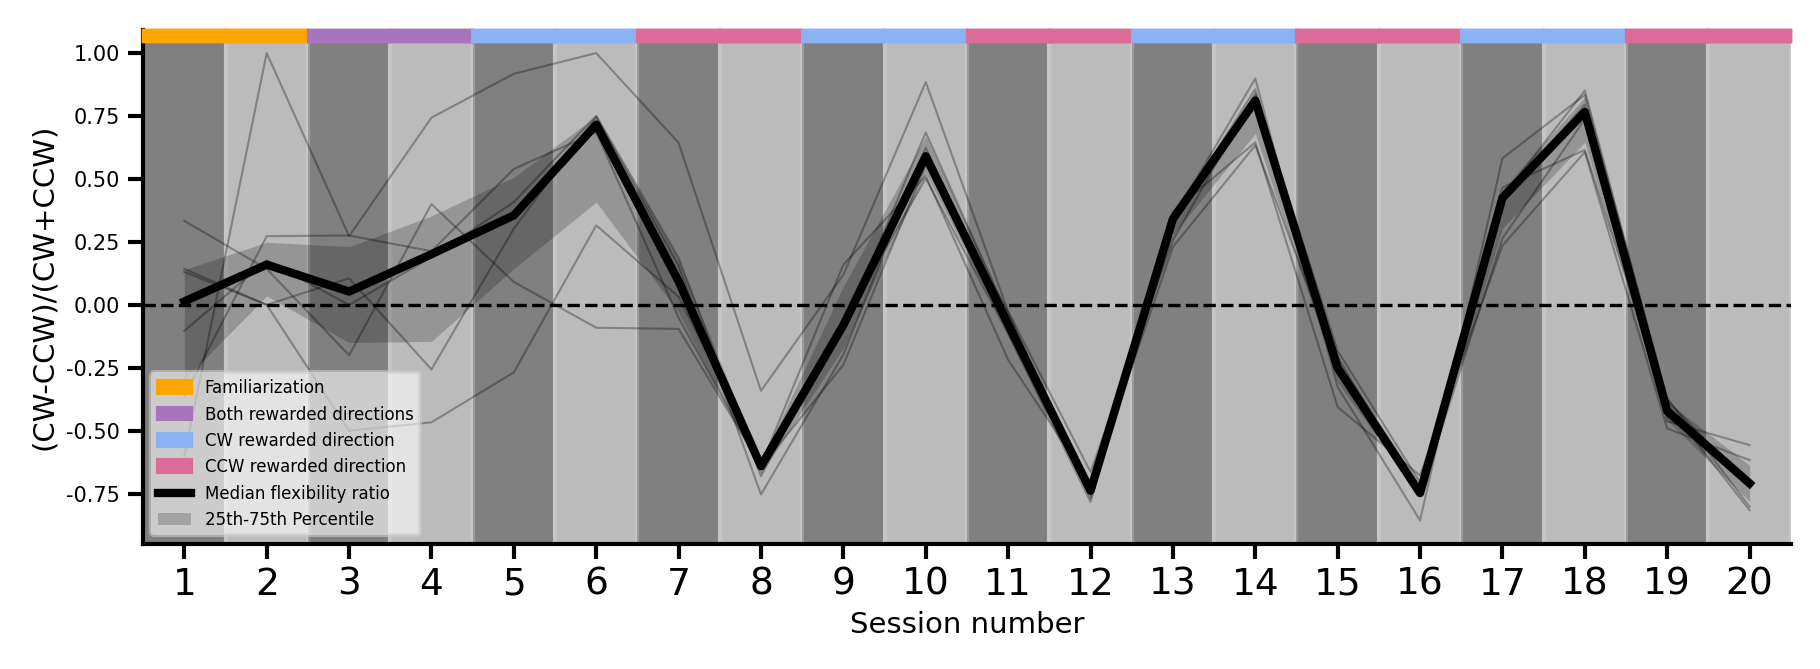

In [38]:
fig=plt.figure(figsize=(cm2inch(18), cm2inch(13)), dpi=300, constrained_layout=False, facecolor='w')
gs = fig.add_gridspec(2, 1 , hspace=0.3, height_ratios=[1, 1])

#########################################

row1 = gs[0].subgridspec(1, 3, wspace=.3, hspace=.3, width_ratios=[1,1,1])

ax_11 = plt.subplot(row1[:])

plot_learning_curves(path_to_data_folder, CW_mice, mouse_flex_ratio_persession, ax_11, ylabel='(CW-CCW)/(CW+CCW)', show_background_legend=True, data_label=['Median flexibility ratio','25th-75th Percentile'])
ax_11.axhline(y=0, color="black", linestyle="--", linewidth=0.8, zorder=1)

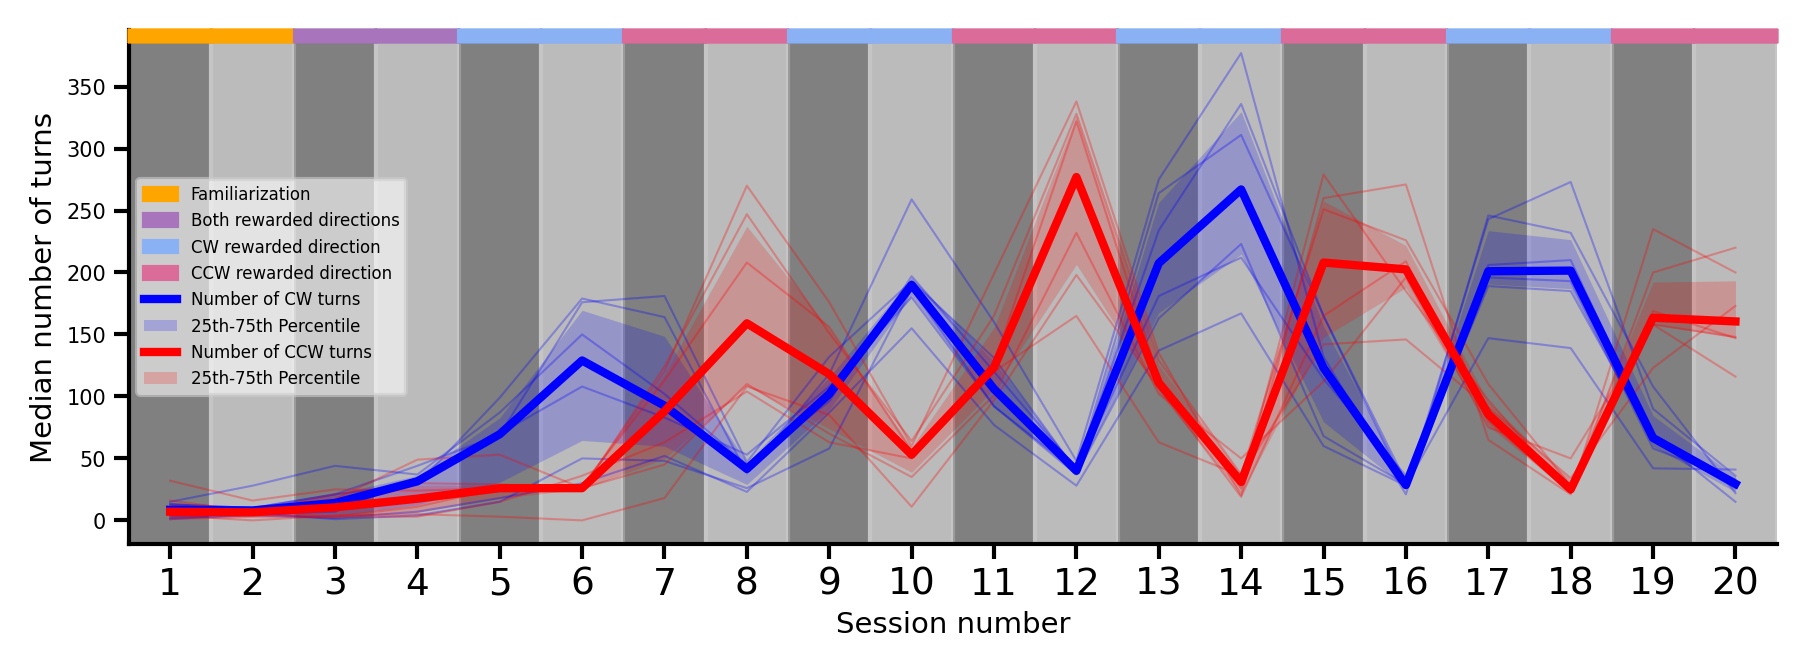

In [39]:
fig=plt.figure(figsize=(cm2inch(18), cm2inch(13)), dpi=300, constrained_layout=False, facecolor='w')
gs = fig.add_gridspec(2, 1 , hspace=0.3, height_ratios=[1, 1])

#########################################

row1 = gs[0].subgridspec(1, 3, wspace=.3, hspace=.3, width_ratios=[1,1,1])

ax_11 = plt.subplot(row1[:])

plot_learning_curves(path_to_data_folder, CW_mice, mouse_CW_number_persession, ax_11, ylabel='Median number of turns', show_background_legend=True, data_label=['Number of CW turns','25th-75th Percentile'], data_color='blue')
plot_learning_curves(path_to_data_folder, CW_mice, mouse_CCW_number_persession, ax_11, ylabel='Median number of turns', show_background_legend=False, data_label=['Number of CCW turns','25th-75th Percentile'], data_color='red')


In [40]:
len(CCW_mice)

7

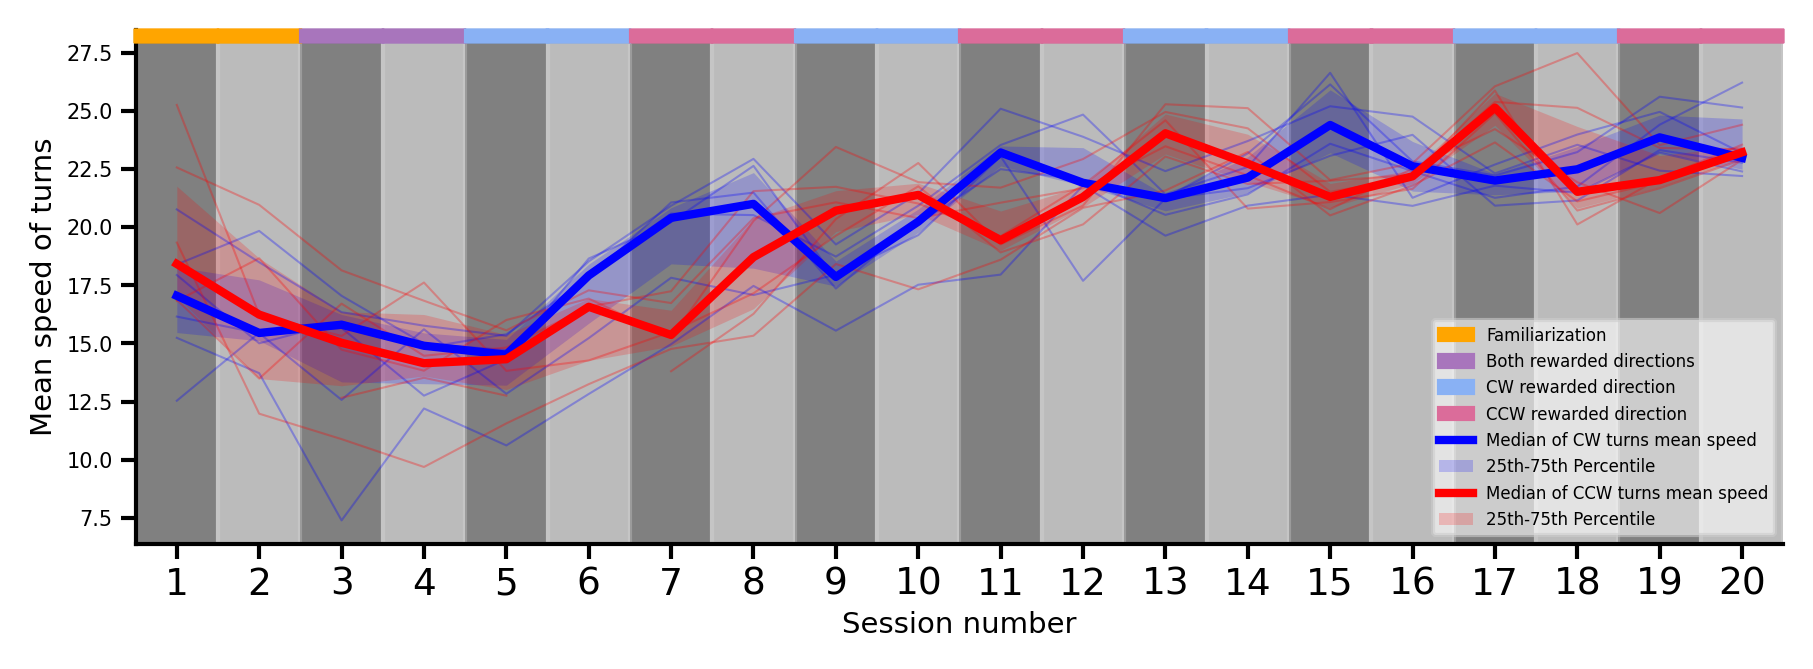

In [41]:
fig=plt.figure(figsize=(cm2inch(18), cm2inch(13)), dpi=300, constrained_layout=False, facecolor='w')
gs = fig.add_gridspec(2, 1 , hspace=0.3, height_ratios=[1, 1])

#########################################

row1 = gs[0].subgridspec(1, 3, wspace=.3, hspace=.3, width_ratios=[1,1,1])

ax_11 = plt.subplot(row1[:])

#plot_learning_curves(path_to_data_folder, mice_to_analyse[3:], mouse_CW_meanspeeds_persession, ax_11, show_legend=False)
plot_learning_curves(path_to_data_folder, CW_mice, mouse_CW_meanspeeds_persession, ax_11, ylabel='Mean speed of turns', show_background_legend=True, data_label=['Median of CW turns mean speed','25th-75th Percentile'], data_color='blue')
plot_learning_curves(path_to_data_folder, CW_mice, mouse_CCW_meanspeeds_persession, ax_11, ylabel='Mean speed of turns', show_background_legend=False, data_label=['Median of CCW turns mean speed','25th-75th Percentile'], data_color='red')

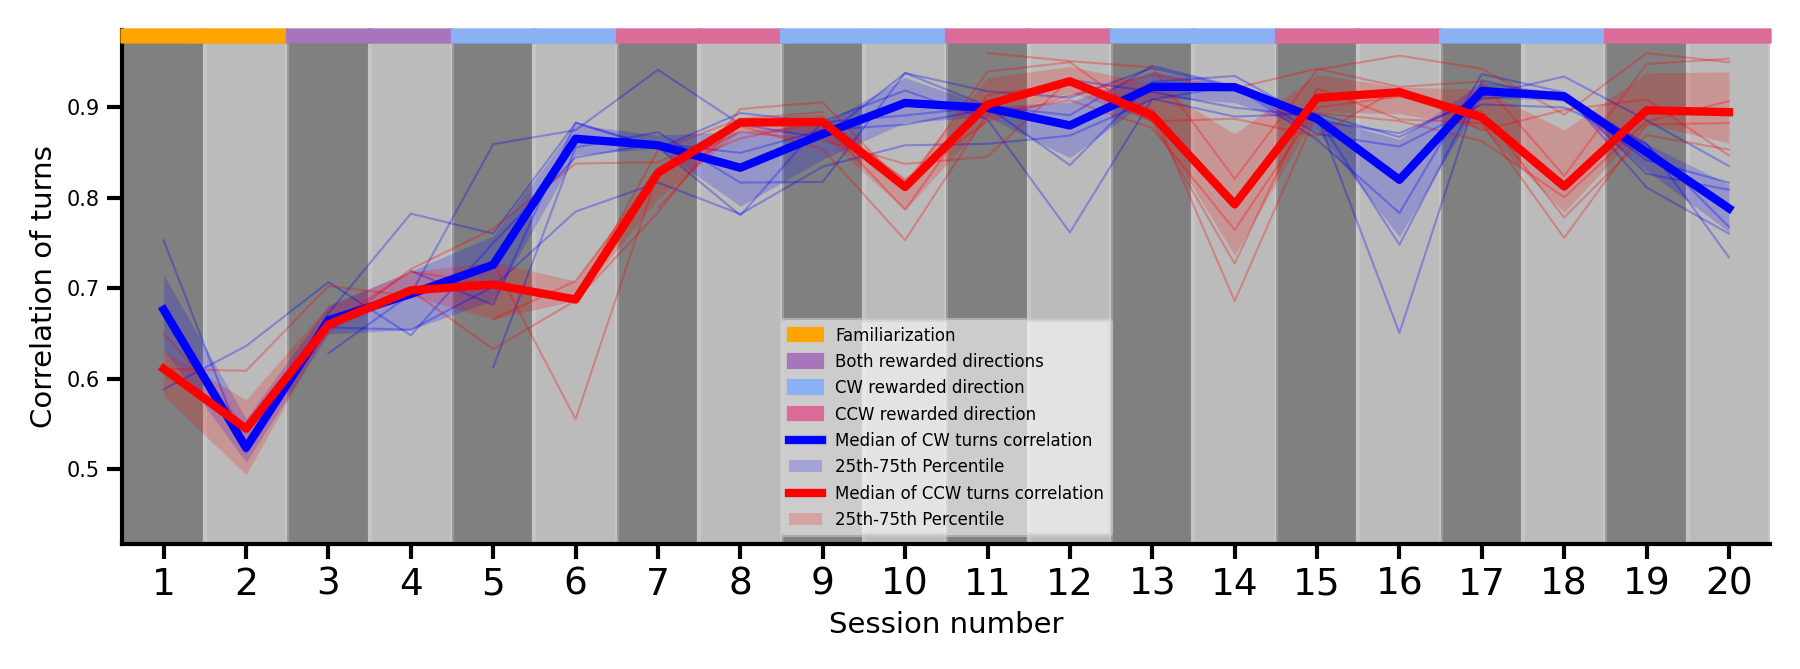

In [42]:
fig=plt.figure(figsize=(cm2inch(18), cm2inch(13)), dpi=300, constrained_layout=False, facecolor='w')
gs = fig.add_gridspec(2, 1 , hspace=0.3, height_ratios=[1, 1])

#########################################

row1 = gs[0].subgridspec(1, 3, wspace=.3, hspace=.3, width_ratios=[1,1,1])

ax_11 = plt.subplot(row1[:])

#plot_learning_curves(path_to_data_folder, mice_to_analyse[3:], mouse_CW_meanspeeds_persession, ax_11, show_legend=False)
plot_learning_curves(path_to_data_folder, CW_mice, overall_CW_per_session, ax_11, ylabel='Correlation of turns', show_background_legend=True, data_label=['Median of CW turns correlation','25th-75th Percentile'], data_color='blue')
plot_learning_curves(path_to_data_folder, CW_mice, overall_CCW_per_session, ax_11, ylabel='Correlation of turns', show_background_legend=False, data_label=['Median of CCW turns correlation','25th-75th Percentile'], data_color='red')

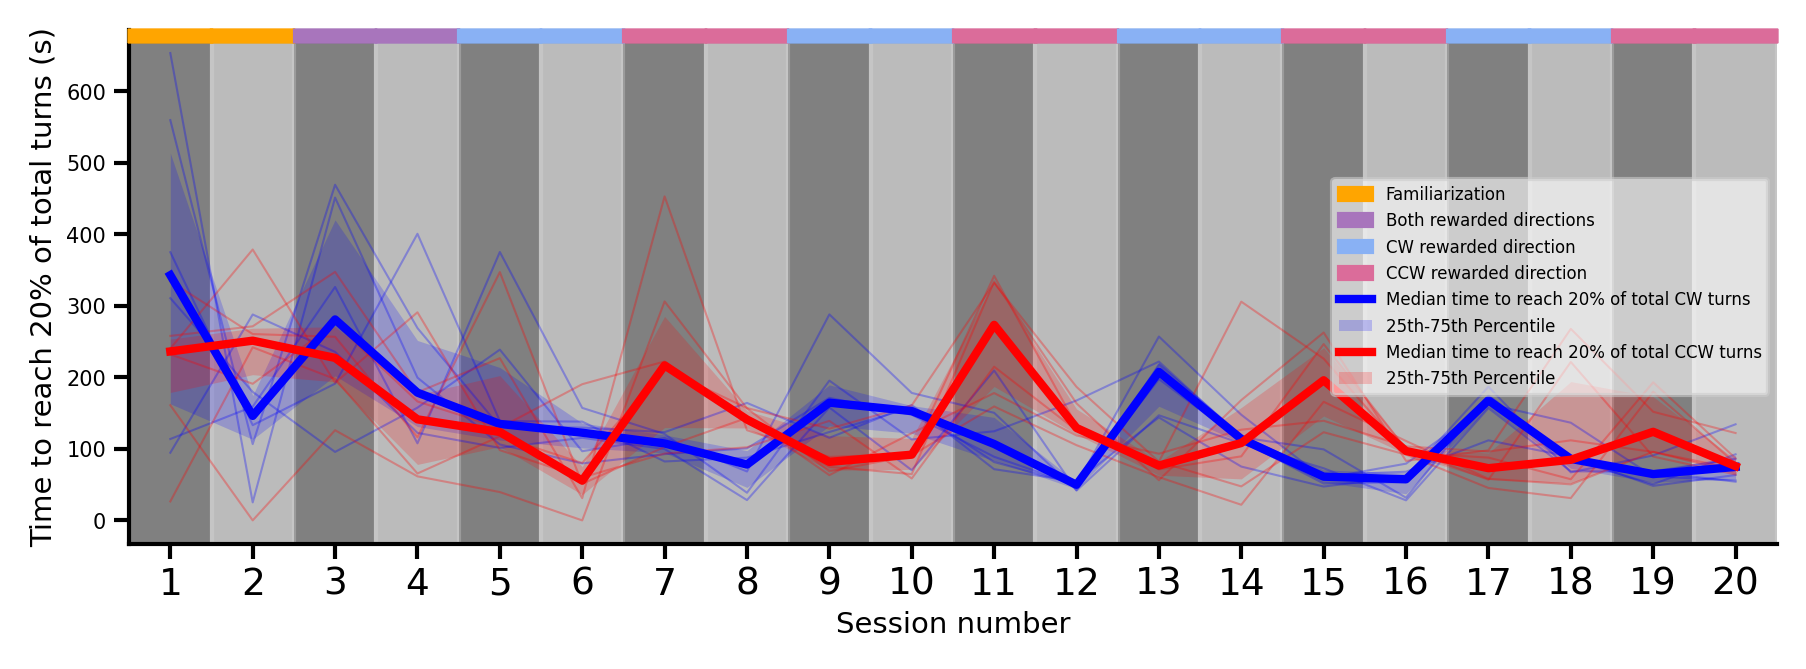

In [66]:
fig=plt.figure(figsize=(cm2inch(18), cm2inch(13)), dpi=300, constrained_layout=False, facecolor='w')
gs = fig.add_gridspec(2, 1 , hspace=0.3, height_ratios=[1, 1])

#########################################

row1 = gs[0].subgridspec(1, 3, wspace=.3, hspace=.3, width_ratios=[1,1,1])

ax_11 = plt.subplot(row1[:])

#plot_learning_curves(path_to_data_folder, mice_to_analyse[3:], mouse_CW_meanspeeds_persession, ax_11, show_legend=False)
plot_learning_curves(path_to_data_folder, CW_mice, mouse_CW_threshold_persession, ax_11, ylabel='Time to reach 20% of total turns (s)', show_background_legend=True, data_label=['Median time to reach 20% of total CW turns','25th-75th Percentile'], data_color='blue')
plot_learning_curves(path_to_data_folder, CW_mice, mouse_CCW_threshold_persession, ax_11, ylabel='Time to reach 20% of total turns (s)', show_background_legend=False, data_label=['Median time to reach 20% of total CCW turns','25th-75th Percentile'], data_color='red')

In [44]:
CCW_mice

['MOU3974', 'MOU3987', 'MOU3992', 'MOU4560', 'MOU4561', 'MOU4562', 'MOU4563']

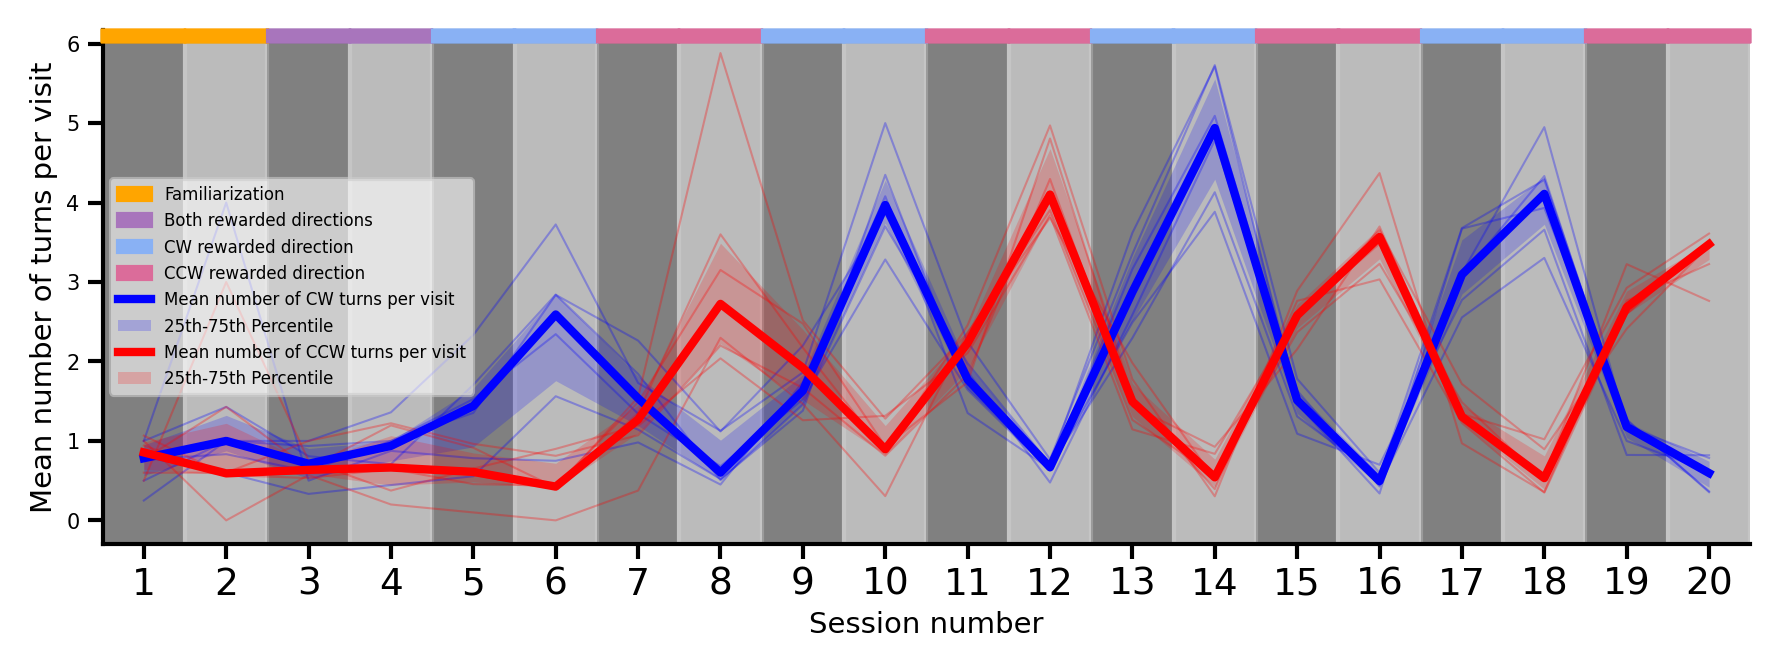

In [ ]:
fig=plt.figure(figsize=(cm2inch(18), cm2inch(13)), dpi=300, constrained_layout=False, facecolor='w')
gs = fig.add_gridspec(2, 1 , hspace=0.3, height_ratios=[1, 1])

#########################################

row1 = gs[0].subgridspec(1, 3, wspace=.3, hspace=.3, width_ratios=[1,1,1])

ax_11 = plt.subplot(row1[:])

#plot_learning_curves(path_to_data_folder, mice_to_analyse[3:], mouse_CW_meanspeeds_persession, ax_11, show_legend=False)
plot_learning_curves(path_to_data_folder, CW_mice, mouse_mean_CW_turns_per_visit, ax_11, ylabel='Mean number of turns per visit', show_background_legend=True, data_label=['Mean number of CW turns per visit','25th-75th Percentile'], data_color='blue')
plot_learning_curves(path_to_data_folder, CW_mice, mouse_mean_CCW_turns_per_visit, ax_11, ylabel='Mean number of turns per visit', show_background_legend=False, data_label=['Mean number of CCW turns per visit','25th-75th Percentile'], data_color='red')

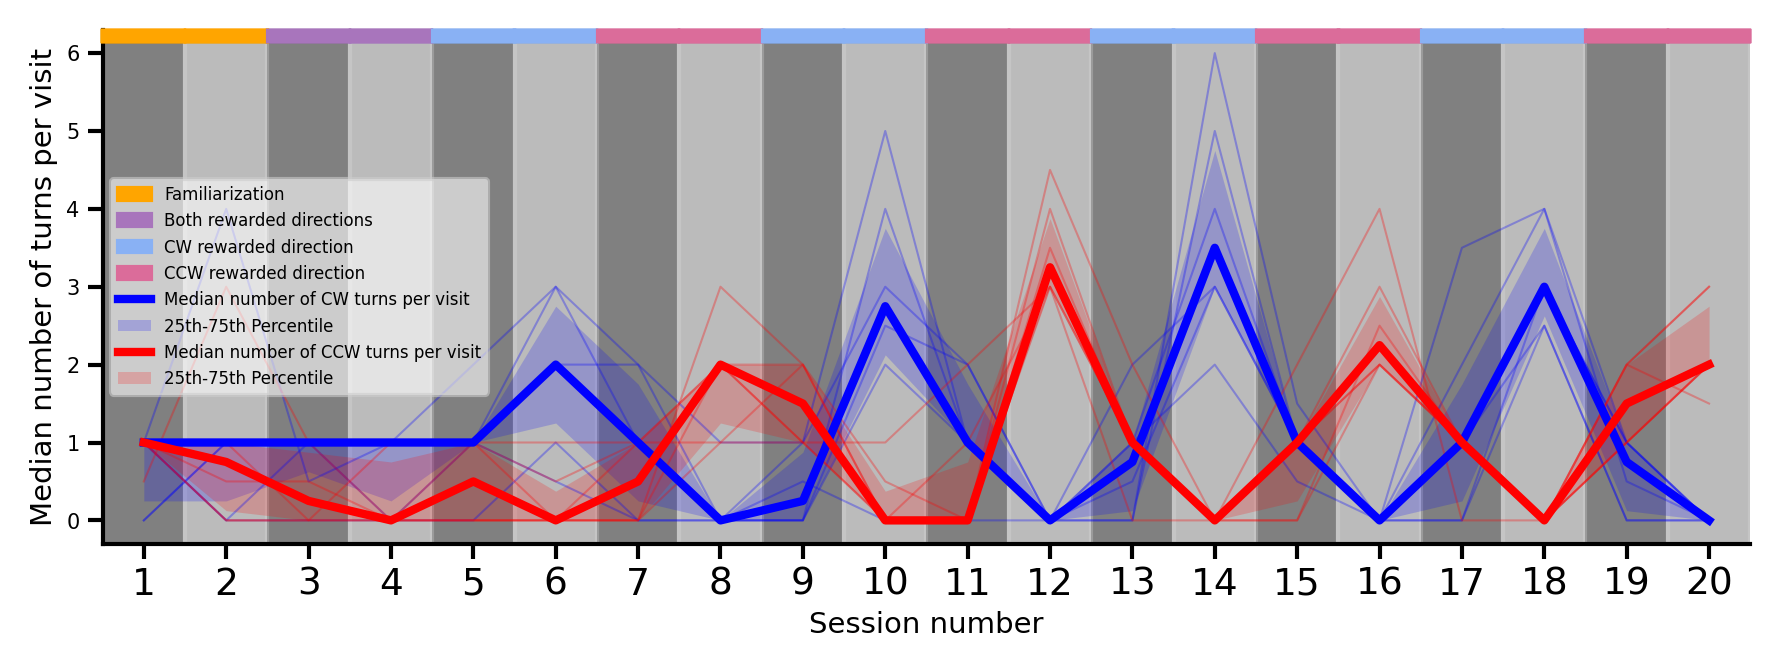

In [63]:
fig=plt.figure(figsize=(cm2inch(18), cm2inch(13)), dpi=300, constrained_layout=False, facecolor='w')
gs = fig.add_gridspec(2, 1 , hspace=0.3, height_ratios=[1, 1])

#########################################

row1 = gs[0].subgridspec(1, 3, wspace=.3, hspace=.3, width_ratios=[1,1,1])

ax_11 = plt.subplot(row1[:])

#plot_learning_curves(path_to_data_folder, mice_to_analyse[3:], mouse_CW_meanspeeds_persession, ax_11, show_legend=False)
plot_learning_curves(path_to_data_folder, CW_mice, mouse_median_CW_turns_per_visit, ax_11, ylabel='Median number of turns per visit', show_background_legend=True, data_label=['Median number of CW turns per visit','25th-75th Percentile'], data_color='blue')
plot_learning_curves(path_to_data_folder, CW_mice, mouse_median_CCW_turns_per_visit, ax_11, ylabel='Median number of turns per visit', show_background_legend=False, data_label=['Median number of CCW turns per visit','25th-75th Percentile'], data_color='red')

In [46]:
def plot_turns_nb_time_profile(folder_path_mouse_to_analyse, session_to_analyse, ax, time_start=None, time_end=None):

    output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"        
    output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)

    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    traject_time = session_data['timeofframes']

    if time_start is None:
        time_start = traject_time[0]
    if time_end is None:
        time_end = traject_time[-1]
  
    CW_turns_per_visit, visits_time, max_rewards = compute_turns_per_visit(folder_path_mouse_to_analyse, session_to_analyse, 'CW')
    CCW_turns_per_visit, visits_time, max_rewards = compute_turns_per_visit(folder_path_mouse_to_analyse, session_to_analyse, 'CCW')

    # ax.plot(visits_time, CW_turns_per_visit, color='blue', label='CW turns number per visit')
    # ax.plot(visits_time, CCW_turns_per_visit, color='red', label='CCW turns number per visit')

    # ax.errorbar(visits_time,np.zeros(len(visits_time)), [np.zeros(len(visits_time)), CW_turns_per_visit], color='blue', label='CW turns number per visit', linewidth=0, elinewidth=1, alpha=1)
    # ax.errorbar(visits_time,np.zeros(len(visits_time)), [np.zeros(len(visits_time)), CCW_turns_per_visit], color='red', label='CCW turns number per visit', linewidth=0, elinewidth=1, alpha=1)

    for i in range(len(visits_time)):

        zorder_CW = -CW_turns_per_visit[i]
        zorder_CCW = -CCW_turns_per_visit[i]

        CW_turn_label = 'CW turns number in visit' if i==0 else ''
        CCW_turn_label = 'CCW turns number in visit' if i==0 else ''
        max_reward_label = 'Maximum reward in visit' if i==0 else ''

        ax.plot([visits_time[i],visits_time[i]], [0,CW_turns_per_visit[i]], color='blue', label=CW_turn_label, linewidth=1, zorder=zorder_CW)
        ax.plot([visits_time[i],visits_time[i]], [0,CCW_turns_per_visit[i]], color='red', label=CCW_turn_label, linewidth=1, zorder=zorder_CCW)

        ax.errorbar([visits_time[i],visits_time[i]], [0,max_rewards[i]], xerr=[0,1.5], color='grey', label=max_reward_label, linewidth=0.25, elinewidth=1, alpha=1, zorder=0)

        # ax.scatter(visits_time[i],max_rewards[i], marker='_', color='black', s=2, linewidth=1)

    ax.axhline(4, linewidth=0.5, color='grey', alpha=0.5)
    ax.axhline(12, linewidth=0.5, color='grey', alpha=0.5)


    ax.set_yticks(range(0, len(visits_time) + 1, 2))

    ax.set_ylim([0,max(CW_turns_per_visit + CCW_turns_per_visit)*1.05])
    
    ax.set_xlabel('Starting time of visit')
    ax.set_ylabel('Number of turns per visit')

    ax.set_title(f'Rewarded direction: {finding_session_rewarded_direction(folder_path_mouse_to_analyse,session_to_analyse)}', fontsize=7)


    ax.legend(fontsize=4, frameon=False)


(0.0, 400.0)

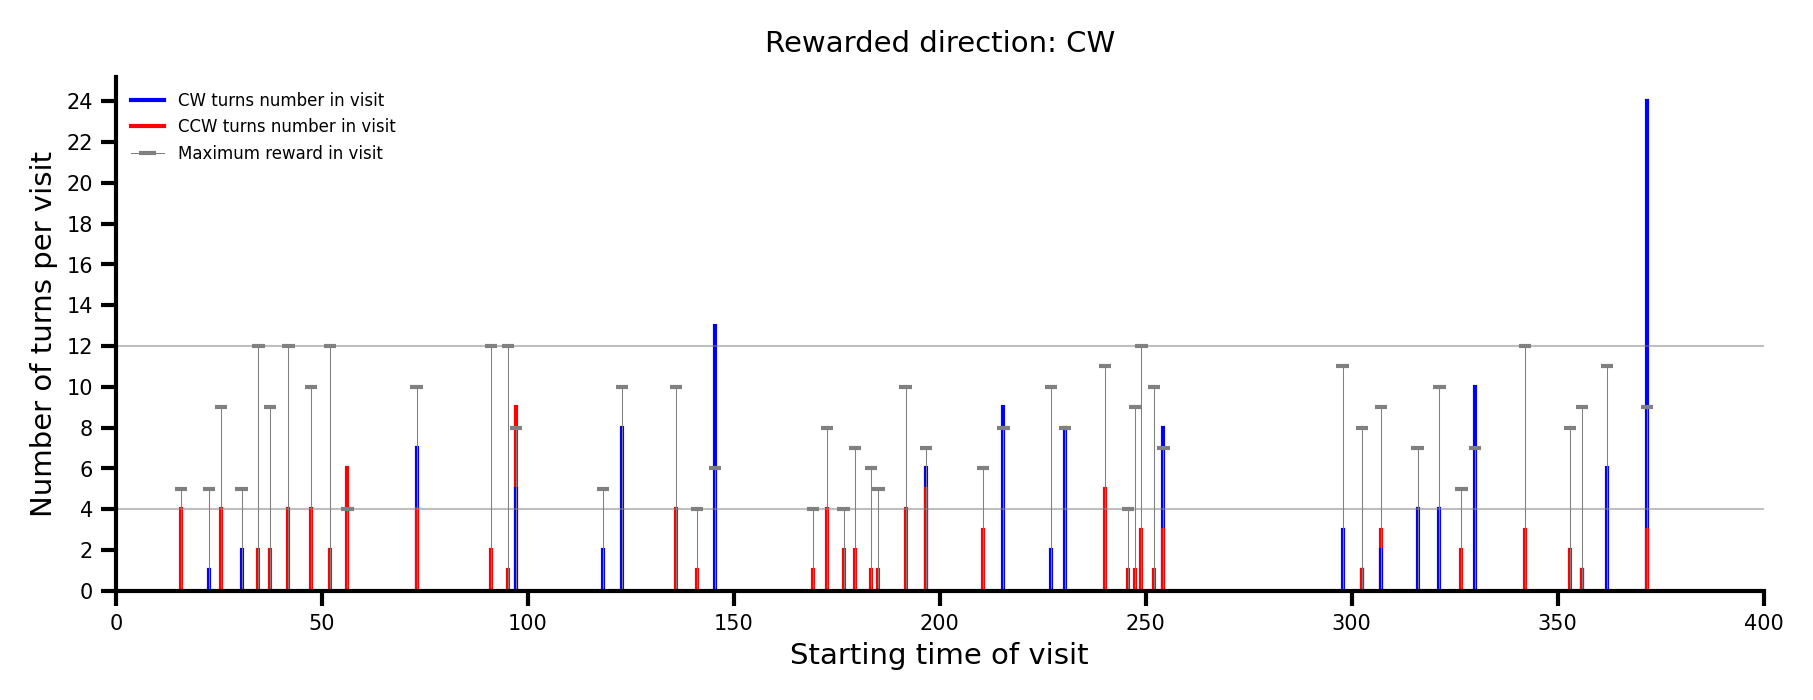

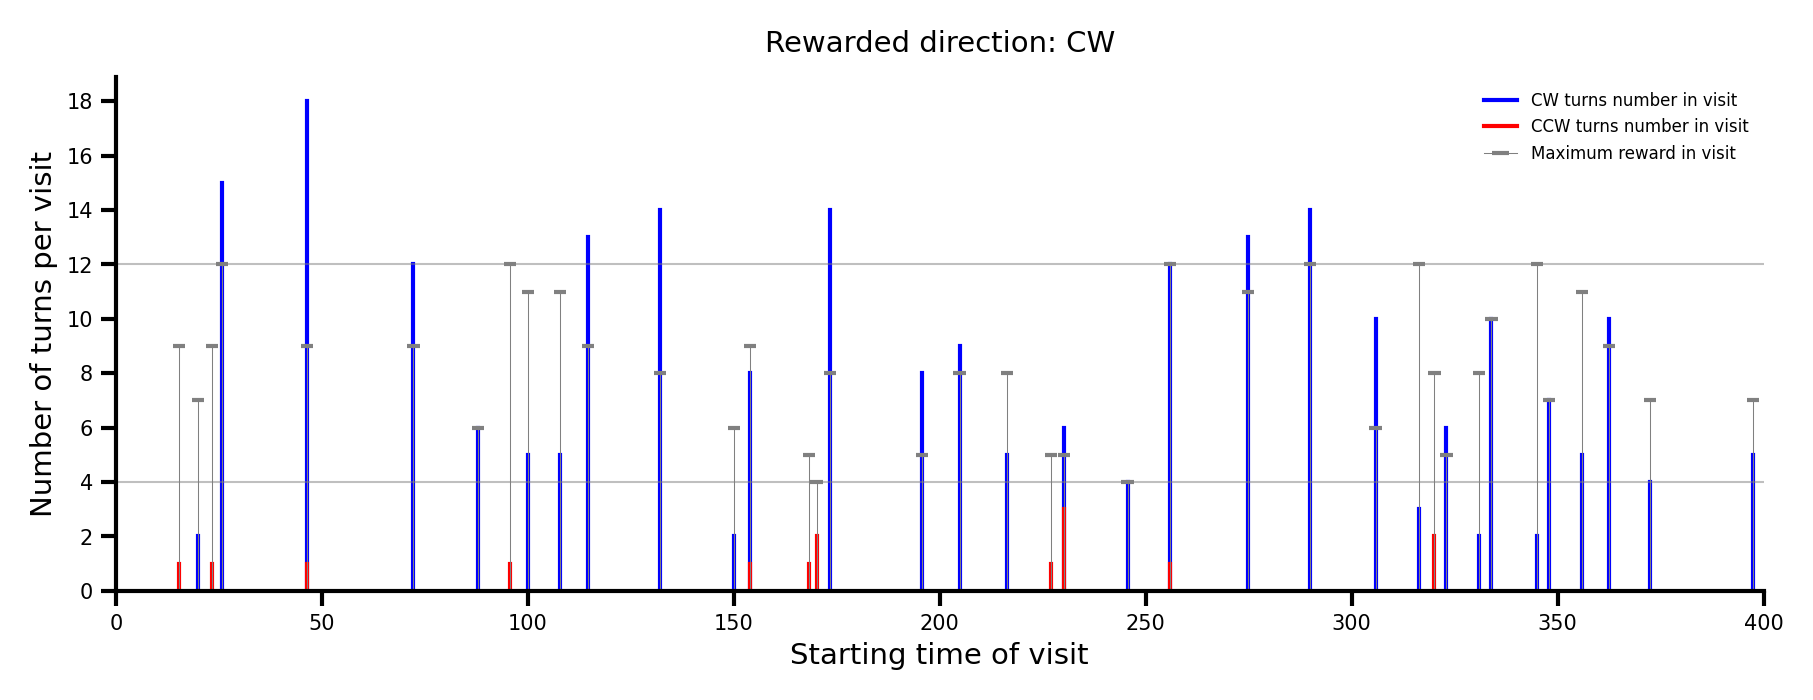

In [47]:
fig=plt.figure(figsize=(cm2inch(18), cm2inch(13)), dpi=300, constrained_layout=False, facecolor='w')
gs = fig.add_gridspec(2, 1 , hspace=0.3, height_ratios=[1, 1])

#########################################

mouse = CW_mice[0]

folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)
    
sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])

sessions_to_analyse = sessions_to_analyse[:session_limit]

session_to_analyse = sessions_to_analyse[12]

#########################################
row1 = gs[0].subgridspec(1, 3, wspace=.3, hspace=.3, width_ratios=[1,1,1])

ax_11 = plt.subplot(row1[:])

plot_turns_nb_time_profile(folder_path_mouse_to_analyse, session_to_analyse, ax_11)
ax_11.set_xlim([0,400])







fig=plt.figure(figsize=(cm2inch(18), cm2inch(13)), dpi=300, constrained_layout=False, facecolor='w')
gs = fig.add_gridspec(2, 1 , hspace=0.3, height_ratios=[1, 1])

#########################################

session_to_analyse = sessions_to_analyse[13]

#########################################
row2 = gs[1].subgridspec(1, 3, wspace=.3, hspace=.3, width_ratios=[1,1,1])

ax_21 = plt.subplot(row1[:])

plot_turns_nb_time_profile(folder_path_mouse_to_analyse, session_to_analyse, ax_21)


ax_21.set_xlim([0,400])

In [48]:
-

SyntaxError: invalid syntax (476313318.py, line 1)

In [63]:
CCW_mice

['MOU3974', 'MOU3987', 'MOU3992', 'MOU4560', 'MOU4561', 'MOU4562', 'MOU4563']

In [70]:

#########################################

mouse = CCW_mice[6]

folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)
    
sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])

sessions_to_analyse = sessions_to_analyse[:session_limit]


with PdfPages(f'/home/david/Pictures/Method_Paper/test_figures/{mouse}.pdf') as pdf:
    
    # Boucle sur toutes les sessions
    
    sessions_for_pdf = np.arange(8,session_limit)
    #sessions_for_pdf = np.concatenate((sessions_for_pdf,[30]))

    for i in sessions_for_pdf:

        #start_time = time.time()
        print(f"Processing session {i+1}...")
        
        fig=plt.figure(figsize=(cm2inch(18), cm2inch(13)), dpi=300, constrained_layout=False, facecolor='w')
        gs = fig.add_gridspec(1, 1 , hspace=0.3, height_ratios=[1])
        
        row = gs[0].subgridspec(1, 3, wspace=.3, hspace=.3, width_ratios=[1,1,1])

        ax = plt.subplot(row1[:])

        session_to_analyse = sessions_to_analyse[i]

        plot_turns_nb_time_profile(folder_path_mouse_to_analyse, session_to_analyse, ax)
        ax.set_xlim([0,None])
        ax.set_ylim([0,session_limit])

        if i%2 == 0:

            time_of_day = 'morning'

        else:

            time_of_day = 'afternoon'

        fig.text(0.45, 0.85, f'Session {i+1} ({time_of_day})', fontsize=7)

        # Création d'une figure pour chaque session

        # Ajout de la figure actuelle au PDF
        pdf.savefig(fig, bbox_inches="tight")

        # Fermeture de la figure pour libérer la mémoire
        plt.close(fig)
        #gc.collect()
        #elapsed_time = time.time() - start_time
        #print(f"Session processed in {elapsed_time:.2f} seconds")

    

    print(f"PDF de {mouse} généré avec succès !")

Processing session 9...
Processing session 10...
Processing session 11...
Processing session 12...
Processing session 13...
Processing session 14...
Processing session 15...
Processing session 16...
Processing session 17...
Processing session 18...
Processing session 19...
Processing session 20...
Processing session 21...
PDF de MOU4563 généré avec succès !


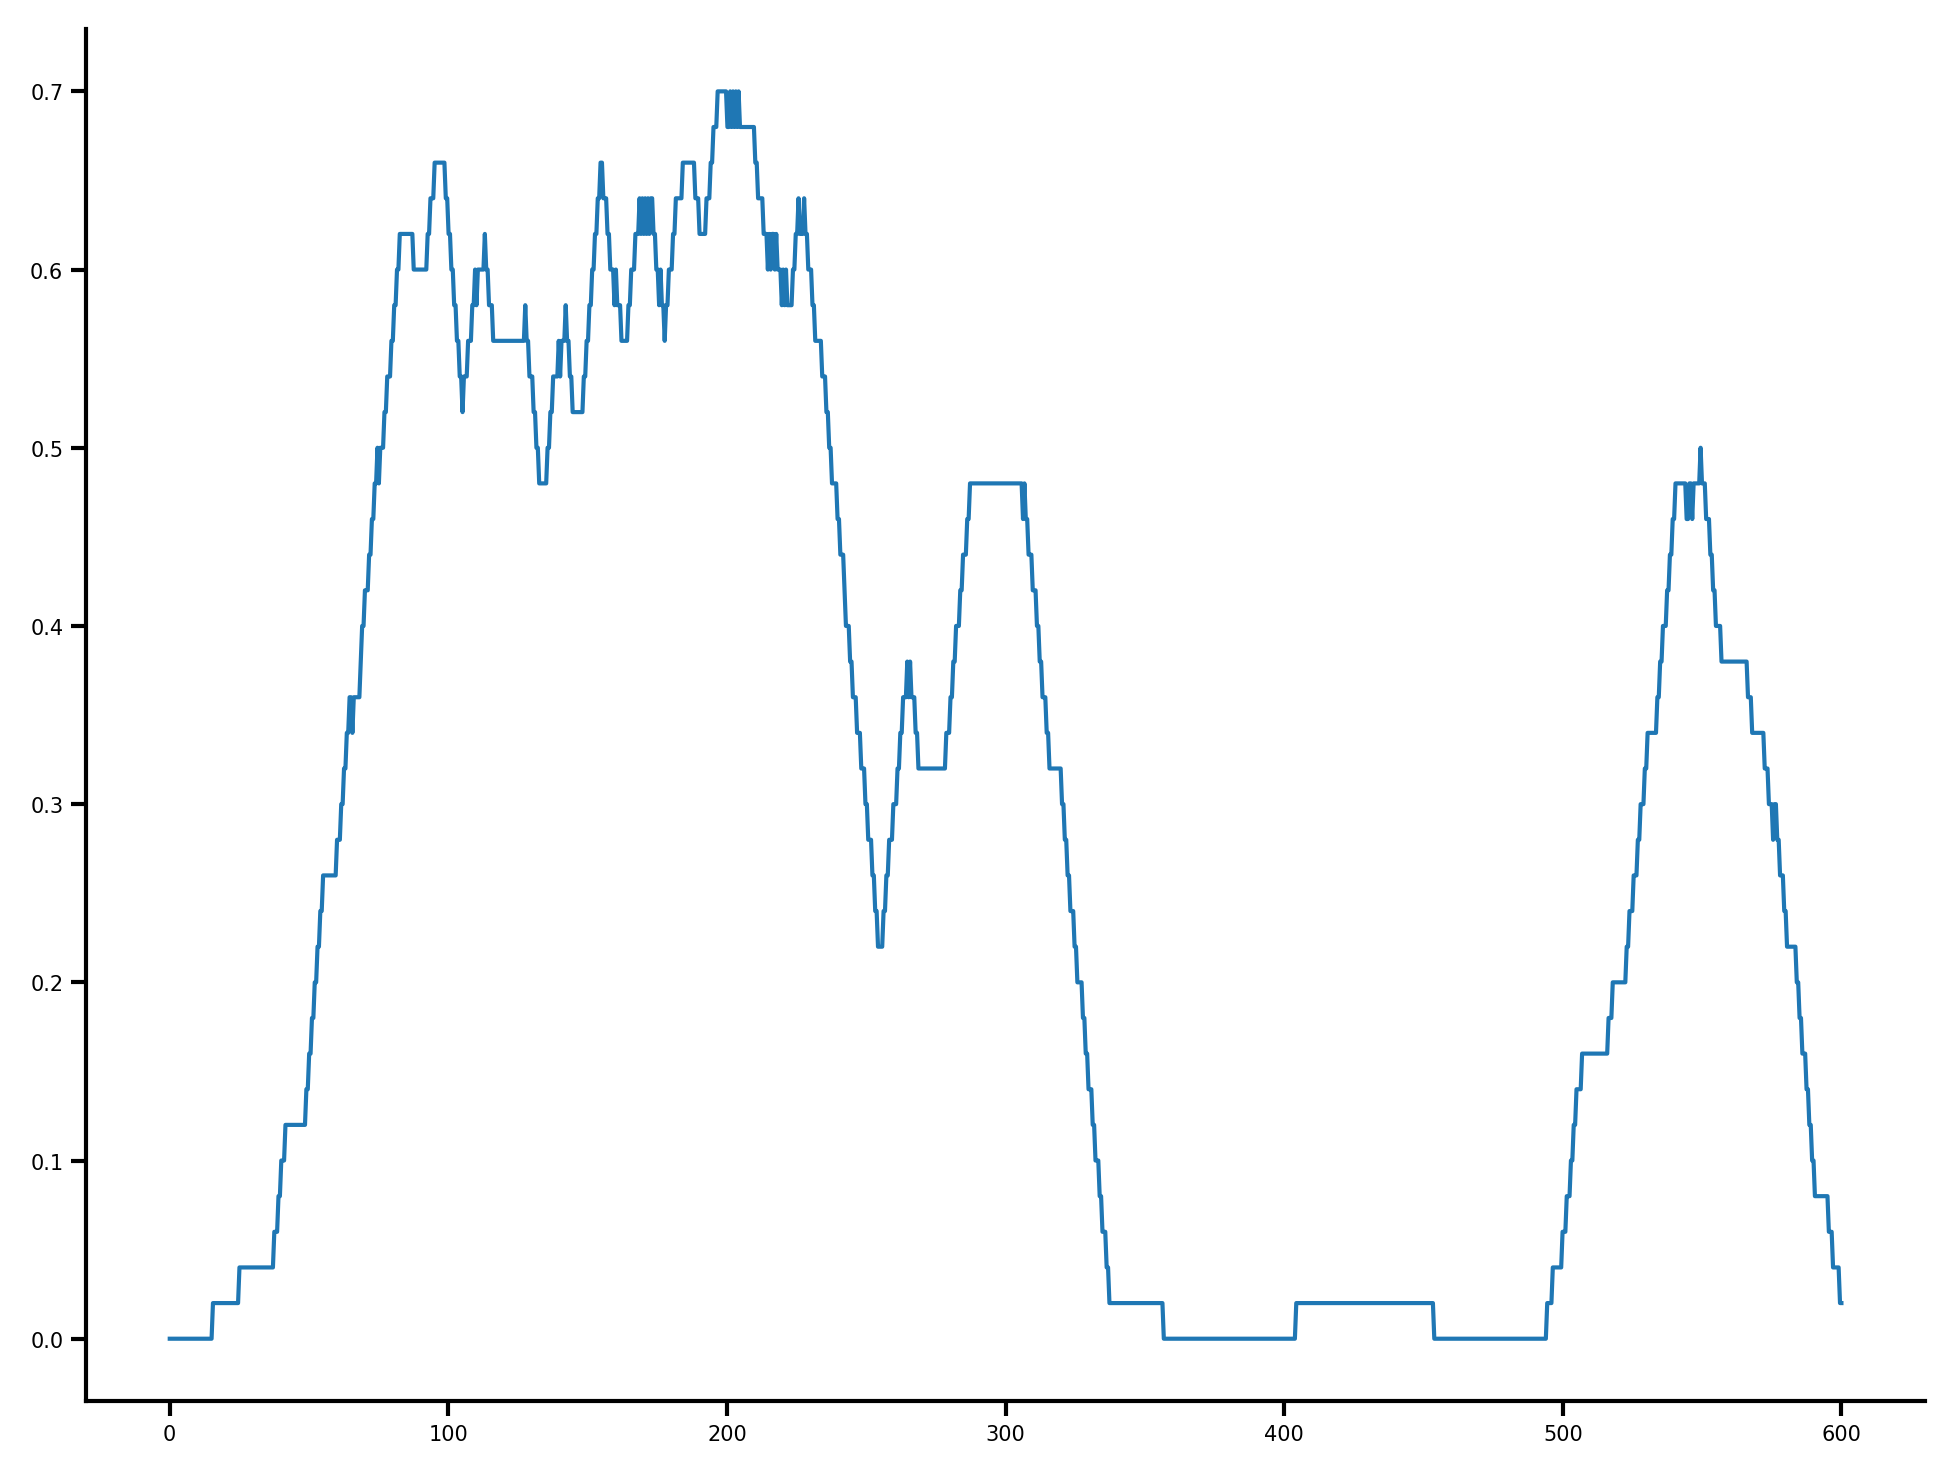

In [60]:
def compute_reward_rate_time_profile(cumulative_reward_time, time_of_frames, time_average_length):

    l = len(cumulative_reward_time)

    reward_rate_list = []

    for i in range(len(time_of_frames)):

        t = time_of_frames[i]

        #t_index = np.searchsorted(cumulative_reward_time, cumulative_reward_time[i]-time_average_length)

        is_higher = cumulative_reward_time>t-time_average_length
        is_lower = cumulative_reward_time<t

        nb_of_reward = len(np.where(np.logical_and(is_higher,is_lower))[0])
        
        reward_rate = nb_of_reward/time_average_length

        reward_rate_list.append(reward_rate)

    return reward_rate_list

#CW_times_sorted, CW_cumulative

time_of_frames = np.linspace(0,600,1200)

y = compute_reward_rate_time_profile(CCW_times_sorted, time_of_frames, 50)

plt.plot(time_of_frames,y)

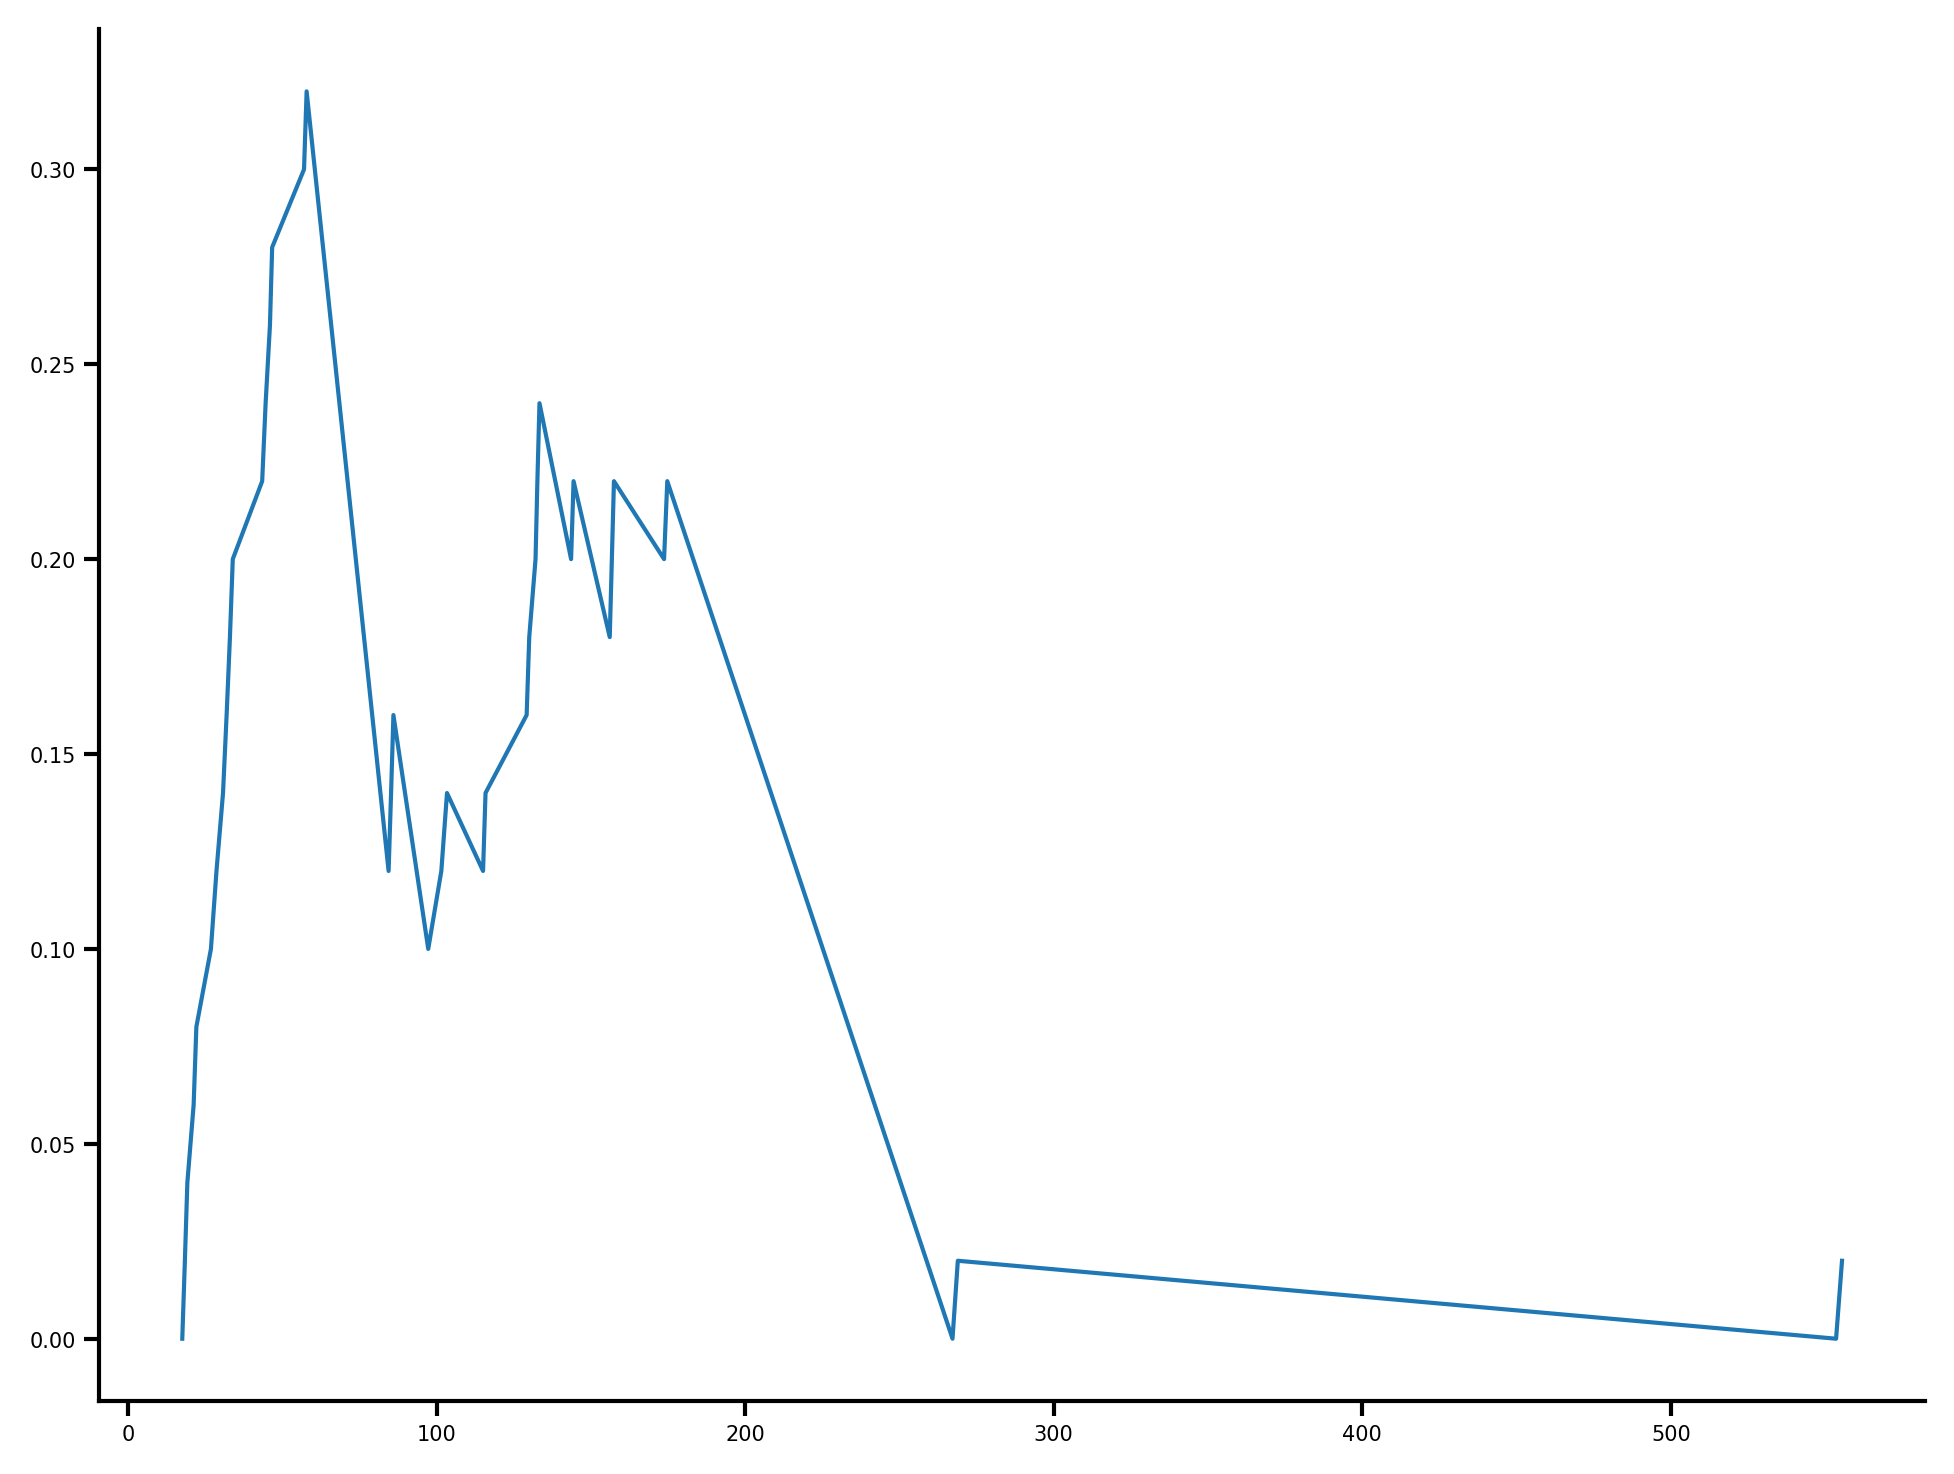

In [57]:
y = compute_reward_rate_time_profile(CW_times_sorted, CW_cumulative, 50)

plt.plot(CW_times_sorted,y)